In [ ]:
# imports
import yfinance as yf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ta
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AveragePooling2D,concatenate,AlphaDropout,LeakyReLU
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
import os
import datetime as dt
from numpy.random import seed
import random
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from tqdm import tqdm
import optuna
import joblib
import ast
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA

In [ ]:
# Import MonteCarlo CV from mccv notebook

# specify working directory
%cd './utils'
import mccv
from mccv import MonteCarloCV

/content/drive/.shortcut-targets-by-id/1s_50o_NM2piIAtPzi6aHDj-XvivZLePw/MADS CAPSTONE/source code/Monte Carlo CV
importing Jupyter notebook from mccv.ipynb


# 0. Set main path

In [ ]:
# These are the path variables

# path to data not retrieved directly from Yfinance
dataset_path = '../data/Dataset_CNN'
# path to pooled cls folder
pooled_CLS_path = '../data/CLS/Pooled_CLS'
# path to overall sentiment df
overall_sent_path = '../data/lexicon/df_overall_sentiment_2014_2020.csv'
# path to lexicon approach for sentiment
loughran_path = '../data/lexicon/df_news_sentiment_LMDictionary.csv'
# path to CLSV3 folder
clsv3_path = '../data/CLS/CLSv3'
# path to Optuna folder
optuna_path = '../data/Optuna'


# 1. Data Acquisition

In [ ]:
# Get Yahoo Finance data

# 1. Create tickers for YFinance
tickers = {'SP500':'^GSPC','DJI':'^DJI','Nasdaq':'^IXIC','RU3000':'^RUA','NI225':'^N225','HangSeng':'^HSI','SSE':'000001.SS',
           'CAC':'^FCHI','FTSE':'^FTSE','DAX':'^GDAXI','JPY':'JPY=X','GBP':'GBPUSD=X','CAD':'CAD=X','CNY':'CNY=X','AUD':'AUDUSD=X','NZD':'NZDUSD=X',
           'CHF':'CHF=X','EUR':'EURUSD=X','Dollar_idx':'DX-Y.NYB','Exxon':'XOM','JPM':'JPM','Apple':'AAPL','MSFT':'MSFT','GE':'GE','J&J':'JNJ',
           'WellsFargo':'WFC','Amazon':'AMZN'}
yf_data = {}

# 2. Create history, remove stocks splits and dividends, convert date as timestamp and set as index
for tick in tickers.keys():
  # retrieve the ticker
  ticker = tickers[tick]
  # get data from Yfinance
  df = yf.Ticker(ticker).history(start='2014-01-01',end='2020-12-31')
  df.reset_index(inplace=True)
  # only keep Close and Date
  df = df[['Date','Close']].copy()
  # convert index with only dates not time info (first extract date as string then reconvert in timestamp), ensure sorting ascending
  df['Date'] = df['Date'].dt.date.astype(str)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date',inplace=True)
  df.sort_index(ascending=True,inplace=True)
  # rename column
  df.columns = [tick+'_Close']
  # compute daily return
  df[tick+'_daily_return'] = df[tick+'_Close'].pct_change(1)
  # drop close price
  df.drop(tick+'_Close',axis=1,inplace=True)
  # drop first row and record
  yf_data[tick] = df.iloc[1:]

<Axes: ylabel='Date'>

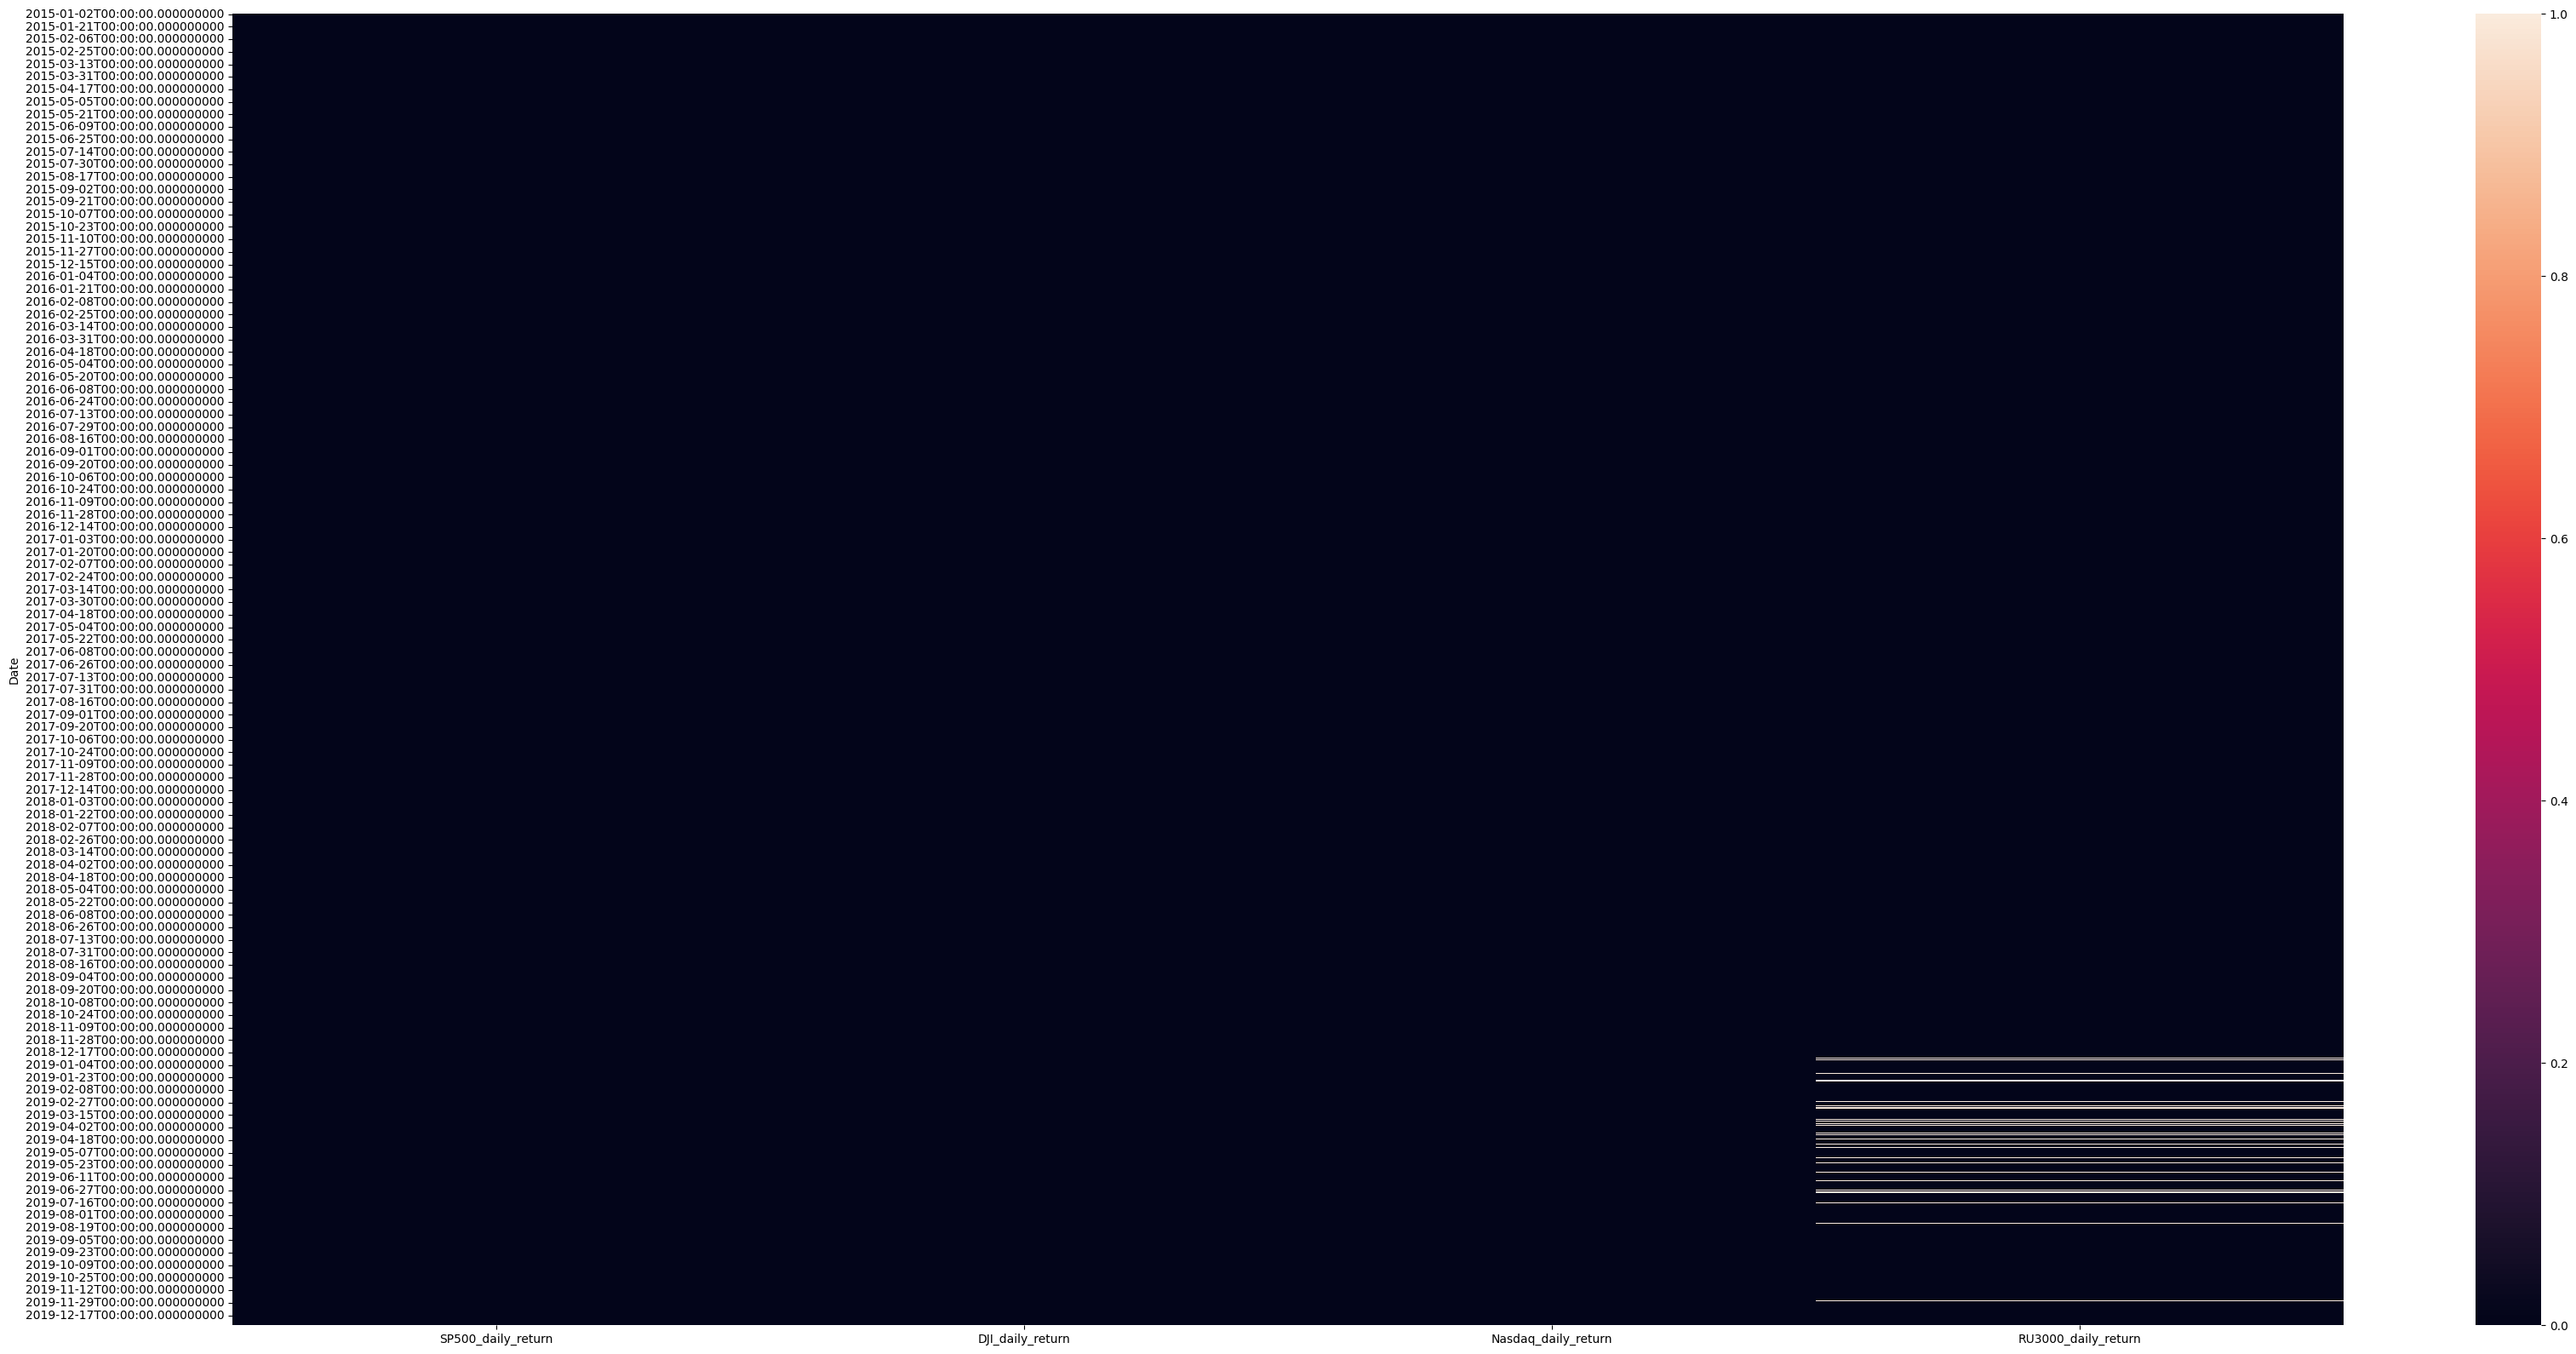

In [ ]:
# let's check if all our indexes trade on same day for the training period 2015-2019
indexes_close = yf_data['SP500']
for mkt in ['DJI','Nasdaq','RU3000']:
  indexes_close = indexes_close.merge(yf_data[mkt],how='outer',left_index=True,right_index=True)

# select our training period and visualize na
plt.figure(figsize = (40,20))
sns.heatmap(indexes_close.loc['2015-01-01':'2019-12-31'].isna())

In [ ]:
# ok just the RU3000 does not trade on exact same days or at least we don't have data

In [ ]:
# 3. Read all csv files and compute daily return
csv_data = {} 

for csv in os.listdir(dataset_path):
  # read files, retrive only price and convert date to timestamp and set as index
  # the first 2 columns are always data and price/quote
  df = pd.read_csv(dataset_path+'/'+csv).iloc[:,:2]
  # rename columns
  df.columns = ['Date','Price']
  # get rid of '.' when no data is available at this date and ',' for separators, convert price to float
  df = df[df['Price']!='.'].copy()
  if df['Price'].dtype==object:
    df['Price'] = df['Price'].apply(lambda x: x.replace(',',''))
    df['Price'] = df['Price'].astype(float)
  # convert to datetime and set date as index, ensure sorted in ascending
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date',inplace=True)
  df.sort_index(ascending=True,inplace=True)
  # compute daily return except if rates data
  if csv.replace('.csv','') not in ['DTB3','DTB6','DTB4WK','DGS5','DGS10','DAAA','DBAA']:
    df[csv.replace('.csv','')+'_daily_return'] = df['Price'].pct_change(1)
    # drop first row and price and record
    df.drop('Price',axis=1,inplace=True)
    csv_data[csv.replace('.csv','')] = df.iloc[1:]
  else:
    df.columns = [csv.replace('.csv','')+'_Price']
    csv_data[csv.replace('.csv','')] = df

In [ ]:
# Read the  various embeddings

## Read embeddings first version
text_test = pd.read_csv(pooled_CLS_path+'/pooled_aggregated_CLS_test_2020.csv')
text_train_uw = pd.read_csv(pooled_CLS_path+'/pooled_aggregated_CLS_training_2015_2019_Unweighted.csv')
text_train_w = pd.read_csv(pooled_CLS_path+'/pooled_aggregated_CLS_training_2015_2019_Weighted.csv')

## Combine the files
text_train_uw.rename(columns={'timestamp':'Date'},inplace=True)
text_train_w.rename(columns={'timestamp':'Date'},inplace=True)
text_test.set_index('Date',inplace=True)
text_train_uw.set_index('Date',inplace=True)
text_train_w.set_index('Date',inplace=True)
text_w = pd.concat([text_train_w,text_test]).sort_index(ascending=True)
text_uw = pd.concat([text_train_uw,text_test]).sort_index(ascending=True)

## 1. Sentiment probability
text_lex = pd.read_csv(overall_sent_path)
text_lex['Date'] = pd.to_datetime(text_lex['timestamp'])
text_lex.set_index('Date',inplace=True)
text_lex.sort_index(inplace=True,ascending=True)
text_lex = text_lex['overall_sentiment'].to_frame().copy()

## 2. Loughran
text_loughran = pd.read_csv(loughran_path)
text_loughran['Date'] = pd.to_datetime(text_loughran['timestamp'])
text_loughran.set_index('Date',inplace=True)
text_loughran.sort_index(inplace=True,ascending=True)
text_loughran.drop(labels=['Unnamed: 0','timestamp'],axis=1,inplace=True)
text_loughran = text_loughran.apply(lambda x: x/x.sum(),axis=1) # we normalize the count of words by the total number of words at a given data

## 3. Pooled_CLSv3

### Iterate through folds 1 to 10
text_v3 = []

for fold in range(1,11):
  if fold>=6:
    path = clsv3_path+f'/fold-{fold}/articles_2015_2019_train_fold-{fold}_CLS-2.txt'
    with open(path, 'r') as j:
      contents = ast.literal_eval(j.read())
    text_train_v3 = pd.DataFrame(contents).T
    path = clsv3_path+f'/fold-{fold}/articles_2015_2019_valid_fold-{fold}_CLS-2.txt'
    with open(path, 'r') as j:
      contents = ast.literal_eval(j.read())
    text_valid_v3 = pd.DataFrame(contents).T
    df = pd.concat([text_train_v3,text_valid_v3]).sort_index(ascending=True)
    # append start and end dates of df that we will use to check what fold it is
    text_v3_fold = (f'fold_{fold}',df.index[0],df.index[-1],df)
  else:
    path = clsv3_path+f'/fold-{fold}/articles_2015_2019_train_fold-{fold}_CLS.txt'
    with open(path, 'r') as j:
      contents = ast.literal_eval(j.read())
    text_train_v3 = pd.DataFrame(contents).T
    path = clsv3_path+f'/fold-{fold}/articles_2015_2019_valid_fold-{fold}_CLS.txt'
    with open(path, 'r') as j:
      contents = ast.literal_eval(j.read())
    text_valid_v3 = pd.DataFrame(contents).T
    df = pd.concat([text_train_v3,text_valid_v3]).sort_index(ascending=True)
    # append start and end dates of df that we will use to check what fold it is
    text_v3_fold = (f'fold_{fold}',df.index[0],df.index[-1],df)

  text_v3.append(text_v3_fold)

# get full dataset
path = clsv3_path+f'/CVs/full/articles_2015_2019_CLS.txt'
with open(path, 'r') as j:
  contents = ast.literal_eval(j.read())
  text_train_v3 = pd.DataFrame(contents).T
path = clsv3_path+f'/CVs/full/articles_2020_CLS.txt'
with open(path, 'r') as j:
  contents = ast.literal_eval(j.read())
  text_valid_v3 = pd.DataFrame(contents).T
df = pd.concat([text_train_v3,text_valid_v3]).sort_index(ascending=True)
# append start and end dates of df that we will use to check what fold it is
text_v3_fold = (f'full',df.index[0],df.index[-1],df)
text_v3.append(text_v3_fold)

# 2. Features Creation

In [ ]:
def prep_data2d(target,target_name):
  '''target: target is a value in the tickers dictionnary
  target_name: key in the tickers dictionnary
  '''
  # merge data, create list of objects
  list_obj = list(csv_data.values())+list(yf_data.values())
  df = list_obj[0]
  for data in list_obj[1:]:
    df = df.merge(right=data,left_index=True,right_index=True,how='outer')
  # create spread data, give same name than in paper
  df['TE1'] = df['DGS10_Price']-df['DTB4WK_Price']
  df['TE2'] = df['DGS10_Price']-df['DTB3_Price']
  df['TE3'] = df['DGS10_Price']-df['DTB6_Price']
  df['TE4']= df['DTB3_Price']-df['DTB4WK_Price']
  df['TE5'] = df['DTB6_Price']-df['DTB4WK_Price']
  df['DE1'] = df['DBAA_Price']-df['DAAA_Price']
  df['DE2'] = df['DBAA_Price']-df['DGS10_Price']
  df['DE3'] = df['DBAA_Price']-df['DTB6_Price']
  df['DE4'] = df['DBAA_Price']-df['DTB3_Price']
  df['DE5'] = df['DBAA_Price']-df['DTB4WK_Price']
  # create day of the week
  df['Day'] = df.index.weekday
  # filter out days for which we have no info on target
  df = df[~df[target_name+'_daily_return'].isna()].copy()
  # add technical indicators to the target
  ## 1. Relative change of volume
  volume = yf.Ticker(target).history(start='2014-01-01',end='2020-12-31')
  volume.reset_index(inplace=True)
  volume['Date'] = volume['Date'].dt.date.astype(str)
  volume['Date'] = pd.to_datetime(volume['Date'])
  volume.set_index('Date',inplace=True)
  volume['Vol_daily_return'] = volume['Volume'].pct_change(1)
  df = df.merge(right=volume['Vol_daily_return'],left_index=True,right_index=True,how='outer')
  # also add the Close price as we will need it just after
  df = df.merge(right=volume['Close'],left_index=True,right_index=True,how='outer')
  df.rename(columns={'Close':target_name+'_Close'},inplace=True)
  ## 2. Return 1,2 and 3,5,10,15 and 20 days before
  df[target_name+'_daily_return_-1d'] = df[target_name+'_daily_return'].shift(1)
  df[target_name+'_daily_return_-2d'] = df[target_name+'_daily_return'].shift(2)
  df[target_name+'_daily_return_-3d'] = df[target_name+'_daily_return'].shift(3)
  df[target_name+'_daily_return_-5d'] = df[target_name+'_daily_return'].shift(5)
  df[target_name+'_daily_return_-10d'] = df[target_name+'_daily_return'].shift(10)
  df[target_name+'_daily_return_-15d'] = df[target_name+'_daily_return'].shift(15)
  df[target_name+'_daily_return_-20d'] = df[target_name+'_daily_return'].shift(20)
  ## 3. Exponential Moving Average at 10,20,50 and 200 days
  df['EMA_10'] = ta.trend.EMAIndicator(close=df[target_name+'_Close'],window=10).ema_indicator()
  df['EMA_20'] = ta.trend.EMAIndicator(close=df[target_name+'_Close'],window=20).ema_indicator()
  df['EMA_50'] = ta.trend.EMAIndicator(close=df[target_name+'_Close'],window=50).ema_indicator()
  df['EMA_200'] = ta.trend.EMAIndicator(close=df[target_name+'_Close'],window=200).ema_indicator()

  # return 5 month before start 2015 and a few month after end of 2020
  start = dt.datetime.strptime('01-01-2014','%m-%d-%Y')
  end = dt.datetime.strptime('03-01-2021','%m-%d-%Y')
  return df.loc[start:end]

In [ ]:
sp500 = prep_data2d('^GSPC','SP500')

<Axes: ylabel='Date'>

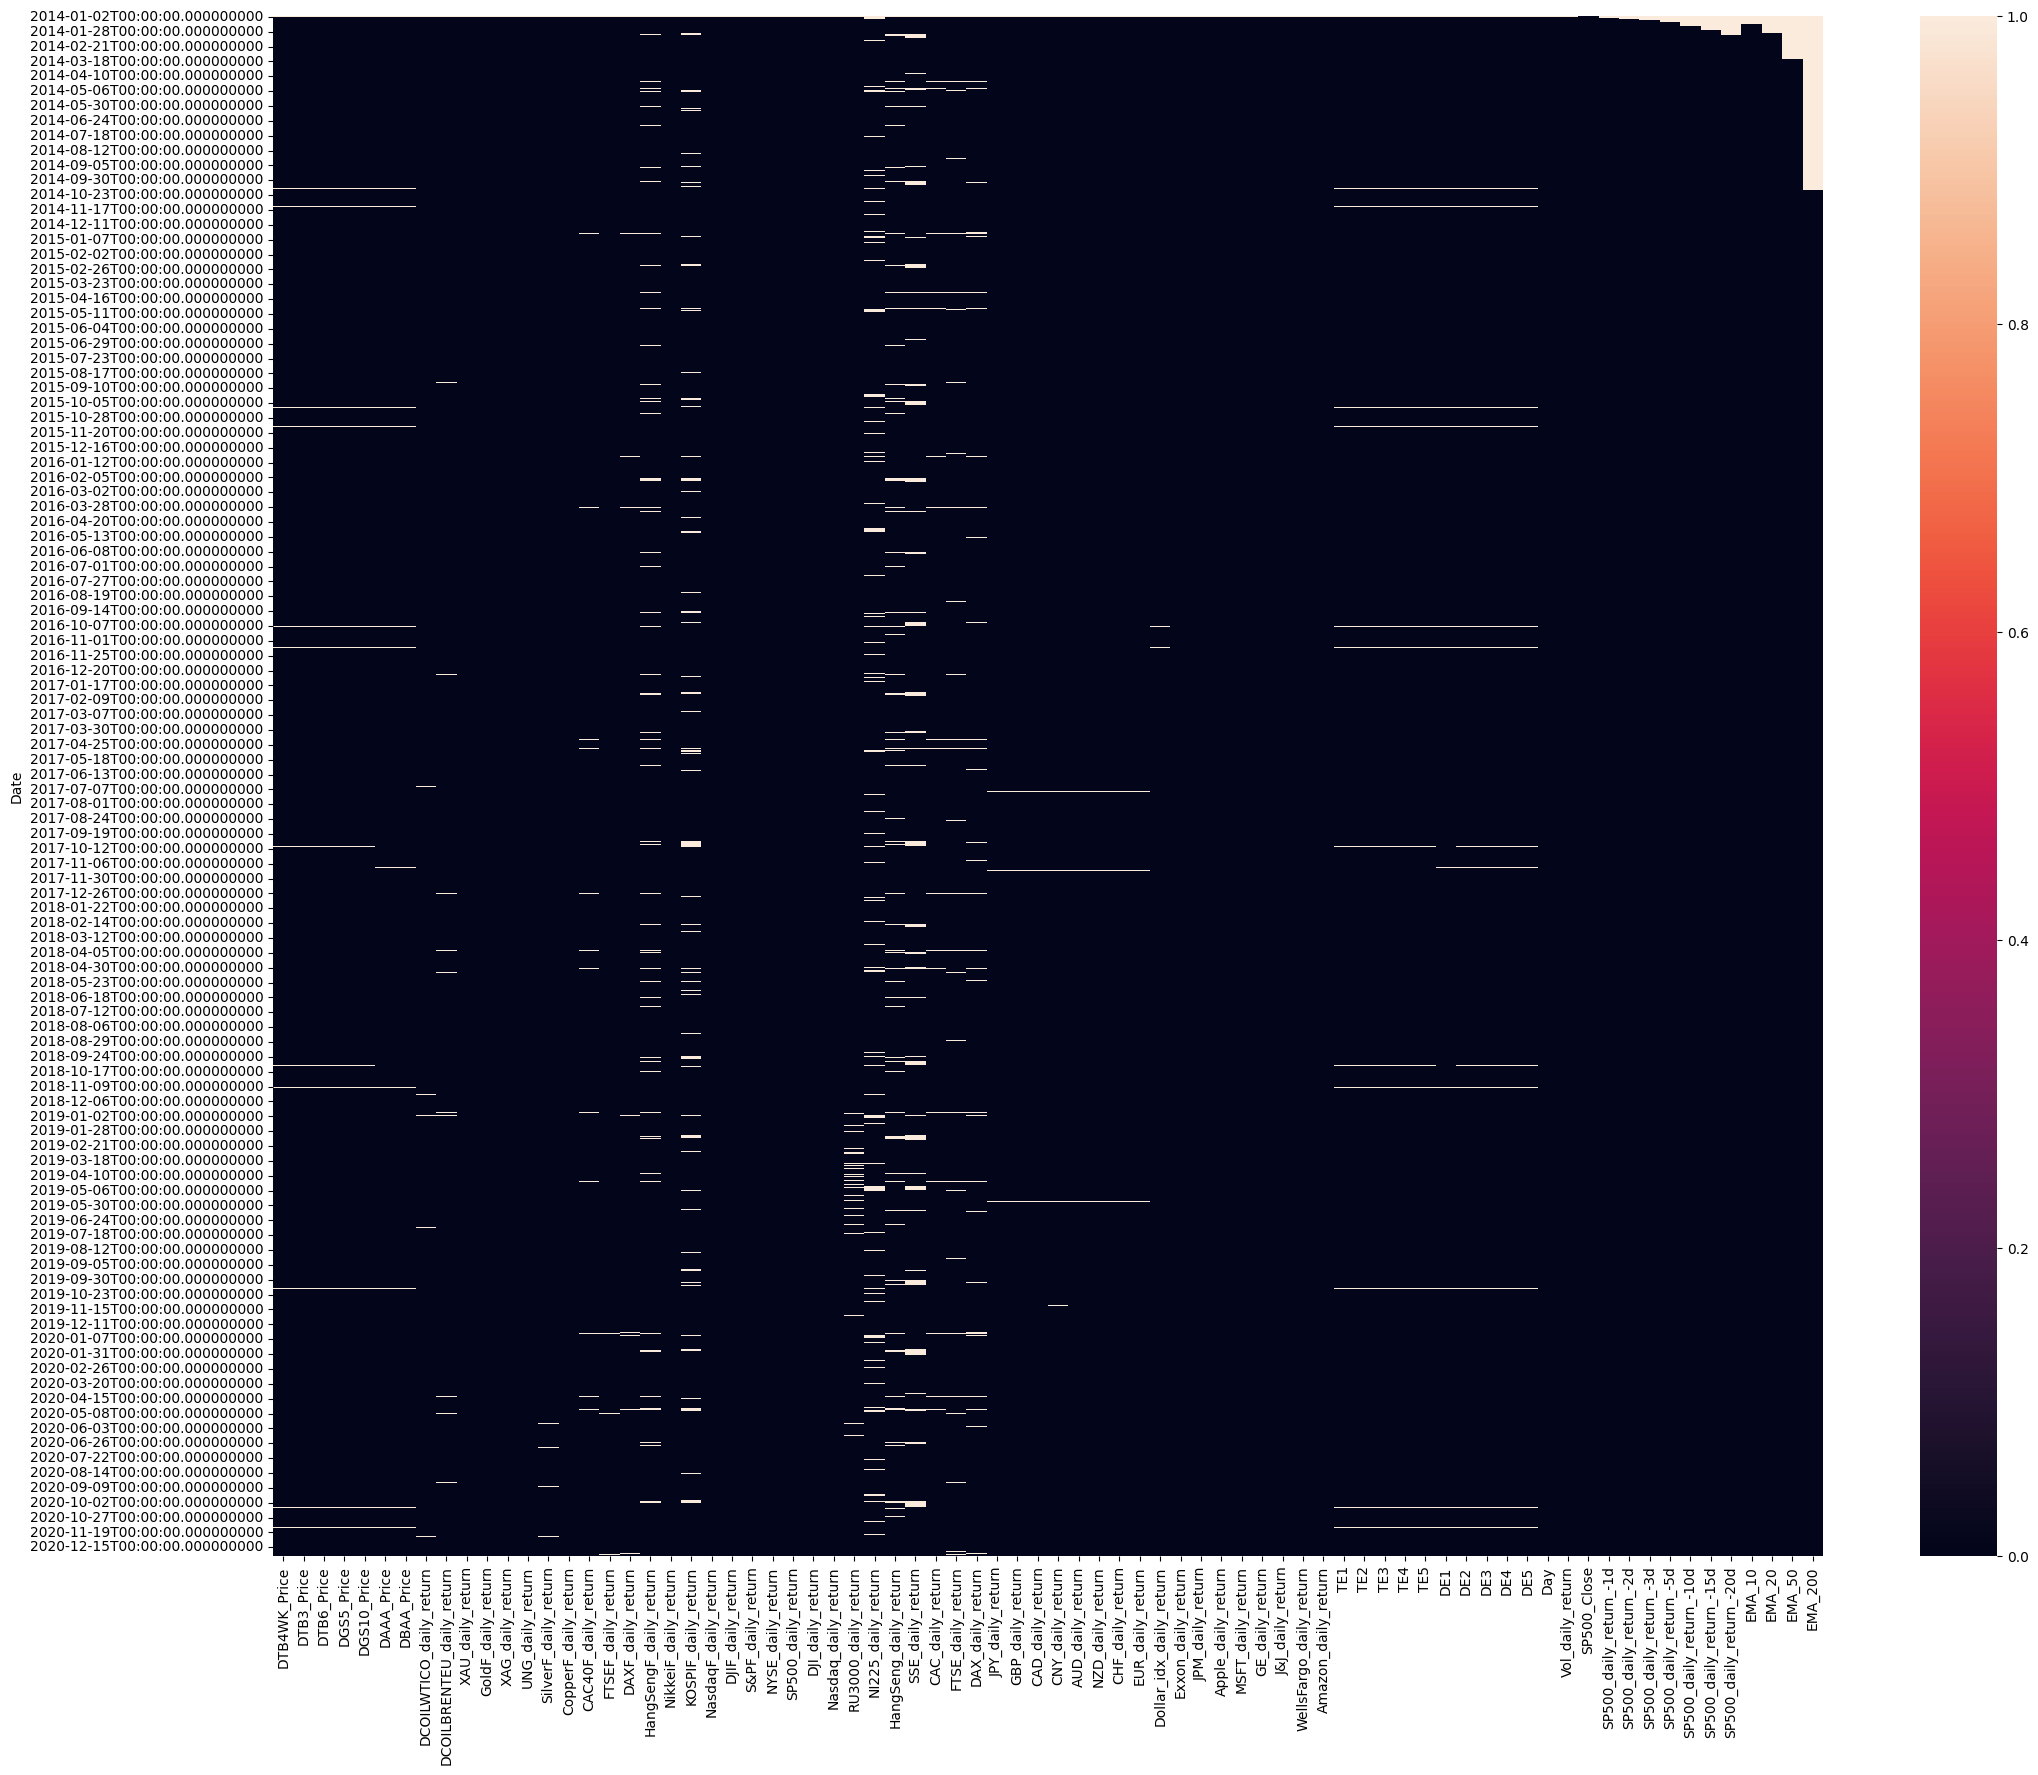

In [ ]:
# visualize missing data
plt.figure(figsize = (25,20))
sns.heatmap(sp500.isna())

In [ ]:
# We can see above that missing data correspond to days where other markets for our targets are close
# we will fill forward on missing values
sp500 = sp500.fillna(method='ffill')

<Axes: ylabel='Date'>

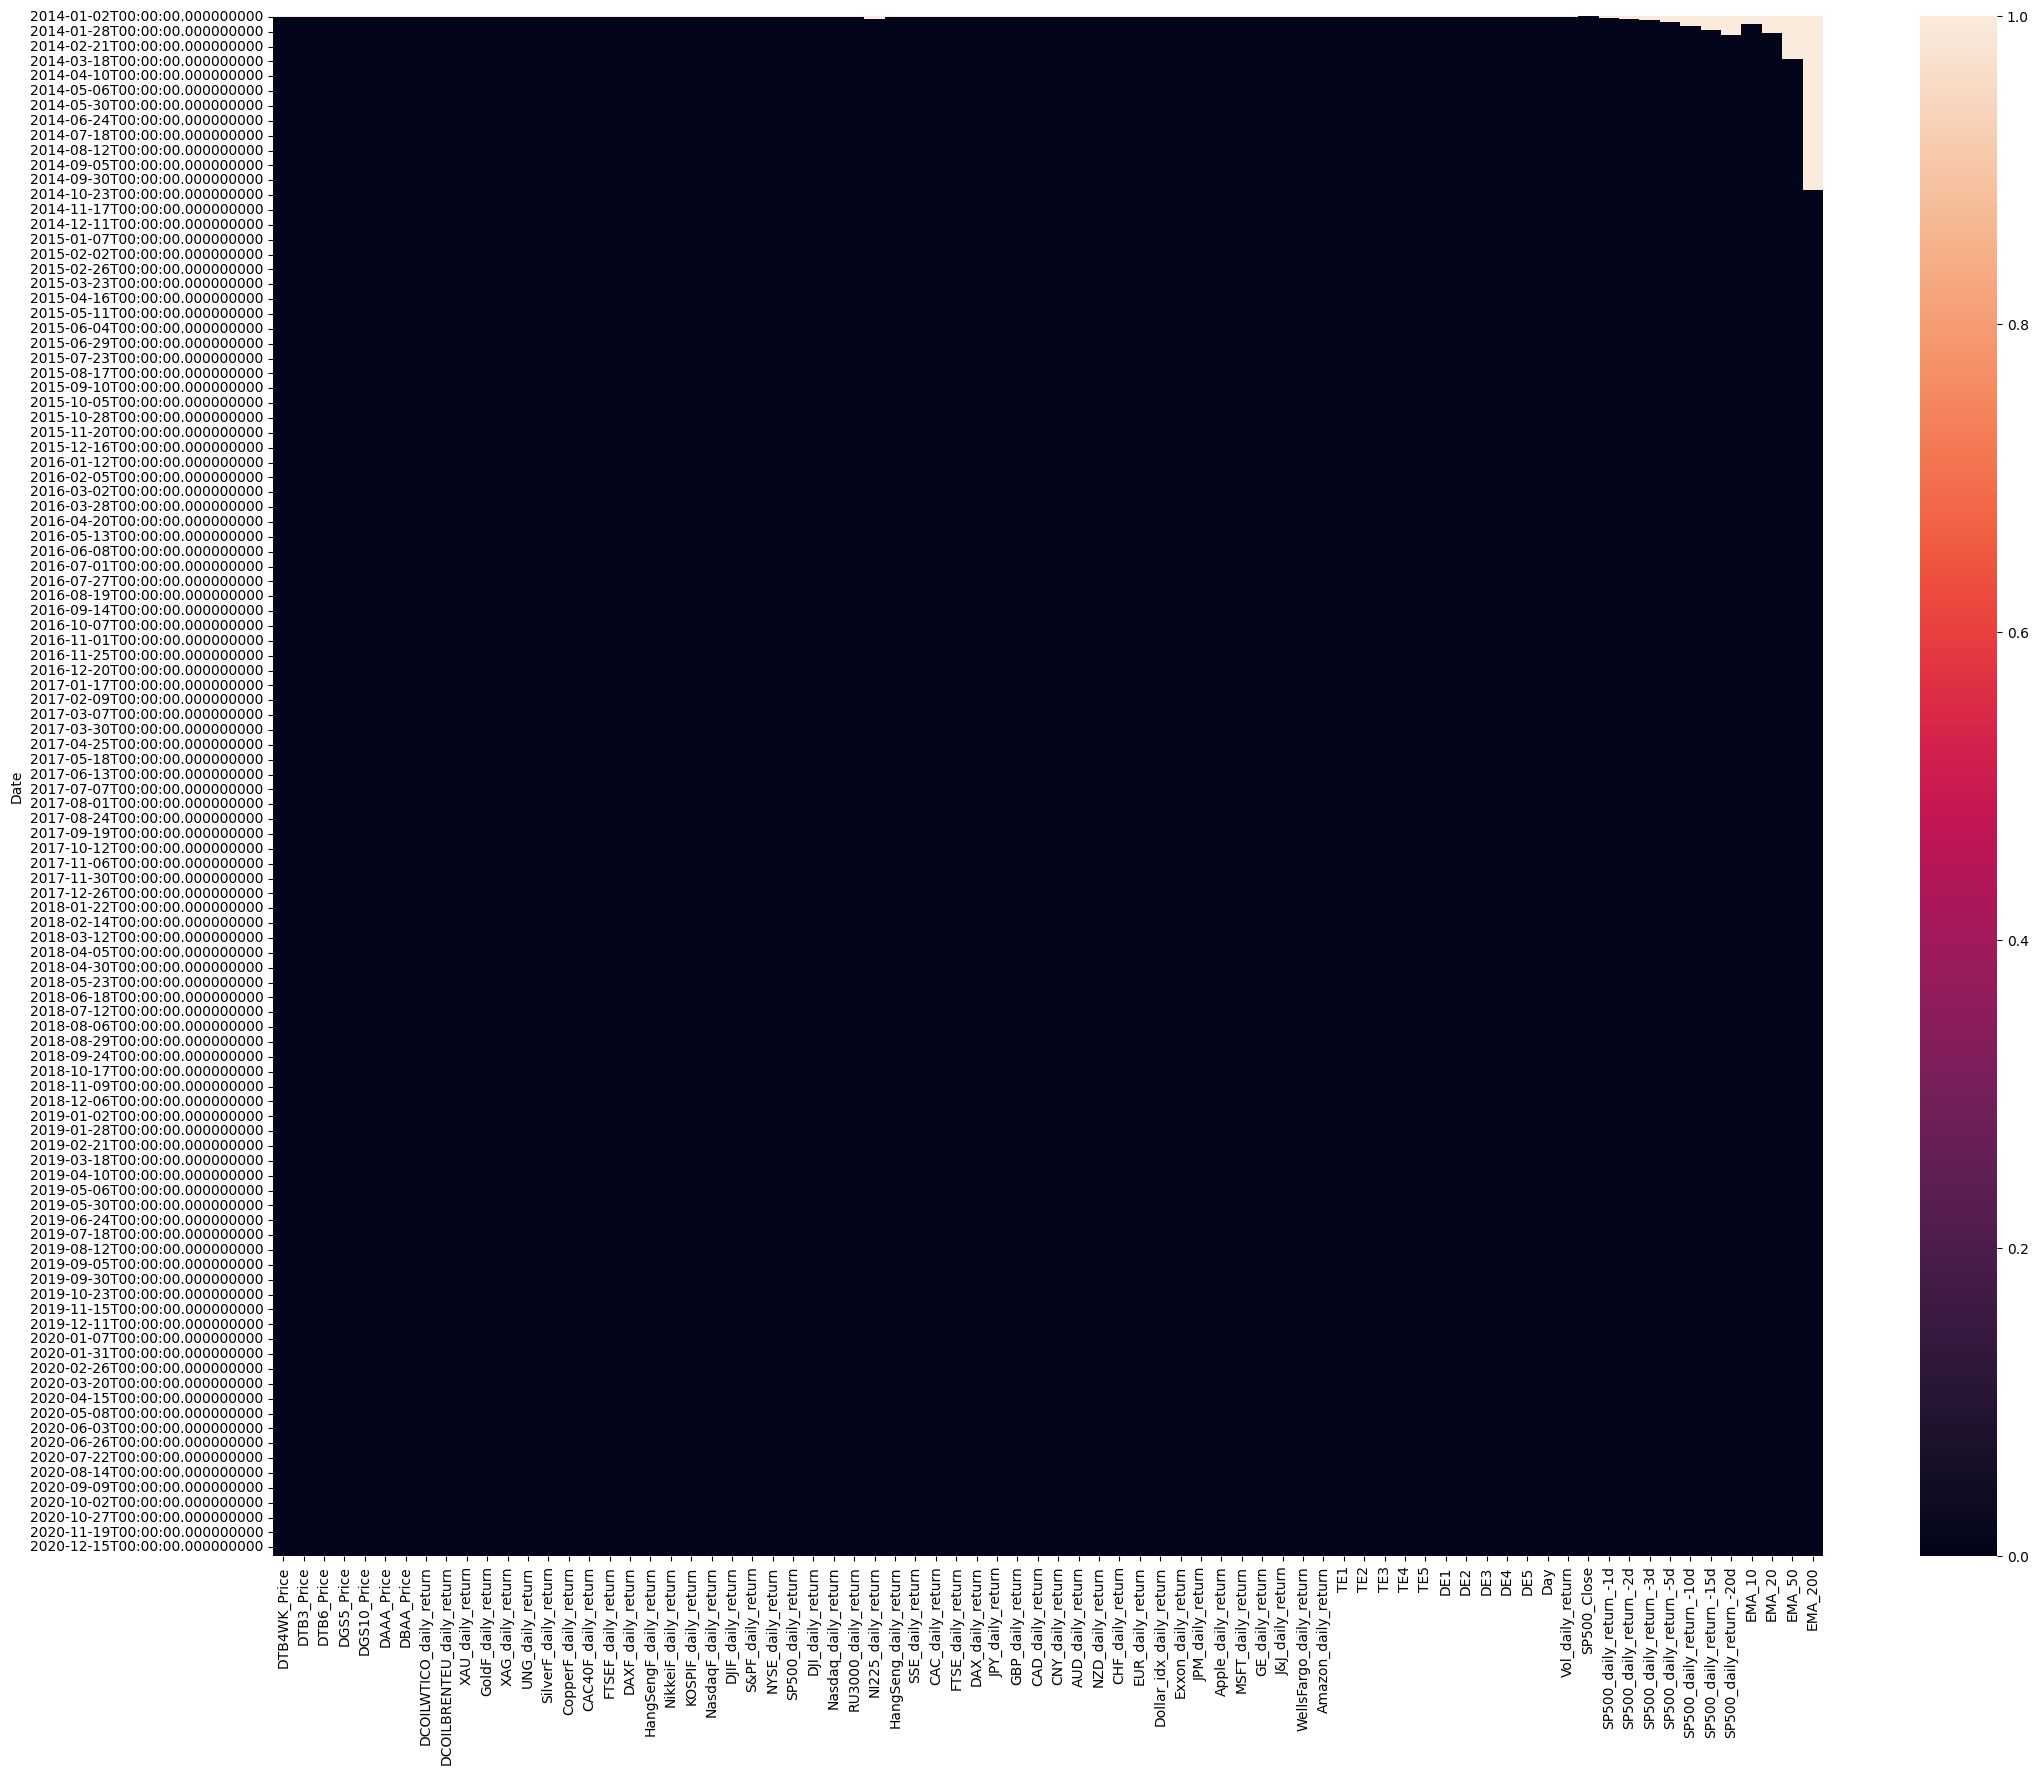

In [ ]:
plt.figure(figsize = (25,20))
sns.heatmap(sp500.isna())

In [ ]:
# ok all good, we just miss data at the start for returns and EMA with long window. This is why we retrieved more data

# 3. Data Preparation

## Create train and test set

In [ ]:
# source code: https://machinelearningmastery.com/using-cnn-for-financial-time-series-prediction/

def gen_train_test2d(seq_len,start_training,start_valid,end_valid,objective='Regression',
                     target_market_name='SP500',target_market_ticker='^GSPC',target_reg='daily_return_+1day',scale=True):

  # get the data anf fill forward na
  df = prep_data2d(target_market_ticker,target_market_name)
  df = df.fillna(method='ffill')

  # define the list of markets
  markets = ['SP500','DJI','Nasdaq','RU3000']
  # remove the non target markets
  to_remove = [x for x in markets if x not in target_market_name]
  to_remove = [x+'_daily_return' for x in to_remove]
  df.drop(labels=to_remove,axis=1,inplace=True)
  
  if objective == 'Classification':
    # create y_target (next day up-->1 else 0)
    df['U/D_+1d'] = df[target_market_name+'_daily_return'].shift(-1).apply(lambda x: 1 if x>0 else 0)
    targetcol = 'U/D_+1d'
  elif objective=='Regression':
    if target_reg=='daily_return_+1day':
      df['daily_return_+1day'] = df[target_market_name+'_daily_return'].shift(-1)
    elif target_reg=='close_+1day':
      df['close_+1day'] = df[target_market_name+'_Close'].shift(-1)
    else:
      print('The target_reg must be daily_return_+1day or close_+1day')
      return None
    targetcol = target_reg
  else:
    print('The objective must be Classification or Regression')
    return None
  
  # restrict df to our range of train and valid
  start_training = dt.datetime.strptime(start_training,'%Y-%m-%d')
  end_valid = dt.datetime.strptime(end_valid,'%Y-%m-%d')
  start_valid = dt.datetime.strptime(start_valid,'%Y-%m-%d')
  df_train = df.loc[start_training:end_valid].copy()


  input_cols = [c for c in df.columns if c != targetcol]
  input_cols_idx = [df.columns.get_loc(c) for c in input_cols]
  # find the start of valid sample as provided
  t = df_train.index[df_train.index >= start_valid][0]
  n = (df_train.index == t).argmax() # find the absolute position of start of valid date

  
  # check if scaling or not
  if scale:
    # normalize features
    sc = StandardScaler()
    # fit scaler on train part
    sc.fit(df_train.iloc[:n,input_cols_idx]) # the train part is up to n-1 so iloc[:n]
    df_train.iloc[:n,input_cols_idx] = sc.transform(df_train.iloc[:n,input_cols_idx])
    # just transform valid
    df_train.iloc[n:,input_cols_idx] = sc.transform(df_train.iloc[n:,input_cols_idx]) # test part starts at n so iloc[n:]


  else:
    # do nothing
    pass

  # instantiate empty batch to create sliding windows
  batch = []
  # extract sample using a sliding window for valid and test
  for i in range(n+1, len(df_train)): # starts at n+1 so first window is up to position n
    frame = df_train.iloc[i-seq_len:i]
    batch.append([frame[input_cols].values, frame[targetcol][-1]])
  X_valid, y_valid = zip(*batch)

  batch = []
  # find the end of train sample
  t = df_train.index[df_train.index < start_valid][-1]
  n = (df_train.index == t).argmax()

  # extract sample using a sliding window
  for i in range(seq_len, n+1):
    frame = df_train.iloc[i-seq_len:i]
    batch.append([frame[input_cols].values, frame[targetcol][-1]])
  X_train, y_train = zip(*batch)
  
  # convert in tensor format
  X_train, y_train = np.expand_dims(np.array(X_train),3), np.array(y_train)
  X_valid, y_valid = np.expand_dims(np.array(X_valid),3), np.array(y_valid)

  return X_train, X_valid,y_train,y_valid


In [ ]:
def gen_train_test_tab(seq_len,start_training,start_valid,end_valid,objective='Regression',
                     target_market_name='SP500',target_market_ticker='^GSPC',target_reg='daily_return_+1day',scale=True):

  # get the data anf fill forward na
  df = prep_data2d(target_market_ticker,target_market_name)
  df = df.fillna(method='ffill')

  # define the list of markets
  markets = ['SP500','DJI','Nasdaq','RU3000']
  # remove the non target markets
  to_remove = [x for x in markets if x not in target_market_name]
  to_remove = [x+'_daily_return' for x in to_remove]
  df.drop(labels=to_remove,axis=1,inplace=True)

  # compute the lags according to lenght of sequence
  if seq_len>0:
    lagged_dfs = []
    for i in range(1,seq_len+1):
      lagged_df = df.shift(i)
      lagged_df.columns = [c+'lag_'+str(i) for c in df.columns]
      lagged_dfs.append(lagged_df)
    # concat the columns
    df = pd.concat([df]+lagged_dfs,axis=1)

  
  if objective == 'Classification':
    # create y_target (next day up-->1 else 0)
    df['U/D_+1d'] = df[target_market_name+'_daily_return'].shift(-1).apply(lambda x: 1 if x>0 else 0)
    targetcol = 'U/D_+1d'
  elif objective=='Regression':
    if target_reg=='daily_return_+1day':
      df['daily_return_+1day'] = df[target_market_name+'_daily_return'].shift(-1)
    elif target_reg=='close_+1day':
      df['close_+1day'] = df[target_market_name+'_Close'].shift(-1)
    else:
      print('The target_reg must be daily_return_+1day or close_+1day')
      return None
    targetcol = target_reg
  else:
    print('The objective must be Classification or Regression')
    return None
  
  # restrict df to our range of train and valid
  start_training = dt.datetime.strptime(start_training,'%Y-%m-%d')
  end_valid = dt.datetime.strptime(end_valid,'%Y-%m-%d')
  start_valid = dt.datetime.strptime(start_valid,'%Y-%m-%d')
  df_train = df.loc[start_training:end_valid].copy()


  input_cols = [c for c in df.columns if c != targetcol]
  input_cols_idx = [df.columns.get_loc(c) for c in input_cols]
  # find the start of valid sample as provided
  t = df_train.index[df_train.index >= start_valid][0]
  n = (df_train.index == t).argmax() # find the absolute position of start of valid date

  
  # check if scaling or not
  if scale:
    # normalize features
    sc = StandardScaler()
    # fit scaler on train part
    sc.fit(df_train.iloc[:n,input_cols_idx]) # the train part is up to n-1 so iloc[:n]
    df_train.iloc[:n,input_cols_idx] = sc.transform(df_train.iloc[:n,input_cols_idx])
    # just transform valid
    df_train.iloc[n:,input_cols_idx] = sc.transform(df_train.iloc[n:,input_cols_idx]) # test part starts at n so iloc[n:]


  else:
    # do nothing
    pass


  # retrieve validation
  X_valid, y_valid = df_train.iloc[n+1:][input_cols], df_train.iloc[n+1:][targetcol]

  # find the end of train sample
  t = df_train.index[df_train.index < start_valid][-1]
  n = (df_train.index == t).argmax()

  # retrieve train
  X_train, y_train = df_train.iloc[:n+1][input_cols], df_train.iloc[:n+1][targetcol]

  return X_train, X_valid,y_train,y_valid

In [ ]:
def gen_train_test2d_text(seq_len,start_training,start_valid,end_valid,objective='Regression',
                     target_market_name='SP500',target_market_ticker='^GSPC',target_reg='daily_return_+1day',scale_features=True,scale_text_features=True,text_data=text_uw):

  # get the data anf fill forward na
  df = prep_data2d(target_market_ticker,target_market_name)
  df = df.fillna(method='ffill')

  # define the list of markets
  markets = ['SP500','DJI','Nasdaq','RU3000']
  # remove the non target markets
  to_remove = [x for x in markets if x not in target_market_name]
  to_remove = [x+'_daily_return' for x in to_remove]
  df.drop(labels=to_remove,axis=1,inplace=True)
  
  # instantiate empty batch to create sliding windows
  batch = []
  if objective == 'Classification':
    # create y_target (next day up-->1 else 0)
    df['U/D_+1d'] = df[target_market_name+'_daily_return'].shift(-1).apply(lambda x: 1 if x>0 else 0)
    targetcol = 'U/D_+1d'
  elif objective=='Regression':
    if target_reg=='daily_return_+1day':
      df['daily_return_+1day'] = df[target_market_name+'_daily_return'].shift(-1)
    elif target_reg=='close_+1day':
      df['close_+1day'] = df[target_market_name+'_Close'].shift(-1)
    else:
      print('The target_reg must be daily_return_+1day or close_+1day')
      return None
    targetcol = target_reg
  else:
    print('The objective must be Classification or Regression')
    return None

  # convert text_data index in time stamp
  text_data.index = pd.to_datetime(text_data.index)

  # join with the text data on the dates. Ignore articles on day the index does not trade, so left merge
  df = df.merge(text_data,how='left',left_index=True,right_index=True)

  # retrieve text data separately now that the index are aligned
  text_data = df[text_data.columns].copy()
  # take out text features from df since now we separate in two df
  df.drop(labels=text_data.columns,axis=1,inplace=True)

  # restrict df to our range of train and valid
  start_training = dt.datetime.strptime(start_training,'%Y-%m-%d')
  end_valid = dt.datetime.strptime(end_valid,'%Y-%m-%d')
  start_valid = dt.datetime.strptime(start_valid,'%Y-%m-%d')
  df_train = df.loc[start_training:end_valid].copy()
  text_train = text_data.loc[start_training:end_valid].copy()

  input_cols = [c for c in df.columns if c != targetcol]
  input_cols_idx = [df.columns.get_loc(c) for c in input_cols]
  # find the start of valid sample as provided
  t = df_train.index[df_train.index >= start_valid][0]
  n = (df_train.index == t).argmax() # find the absolute position of start of valid date

  # check if normalization
  if scale_features:
  # normalize features
    sc = StandardScaler()
    # fit scaler on train part
    sc.fit(df_train.iloc[:n,input_cols_idx]) # the train part is up to n-1 so iloc[:n]
    df_train.iloc[:n,input_cols_idx] = sc.transform(df_train.iloc[:n,input_cols_idx])
    # just transform valid
    df_train.iloc[n:,input_cols_idx] = sc.transform(df_train.iloc[n:,input_cols_idx]) # test part starts at n so iloc[n:]


  if scale_text_features:
  # normalize features
    sc = StandardScaler()
    # fit scaler on train part
    sc.fit(text_train.iloc[:n]) # the train part is up to n-1 so iloc[:n]
    text_train.iloc[:n] = sc.transform(text_train.iloc[:n])
    # just transform valid and overall df that we will use to define test
    text_train.iloc[n:] = sc.transform(text_train.iloc[n:]) # test part starts at n so iloc[n:]


  # extract sample using a sliding window for valid and test
  for i in range(n+1, len(df_train)): # starts at n+1 so first window is up to position n
    frame = df_train.iloc[i-seq_len:i]
    frame_text = text_train.iloc[i-seq_len:i]
    batch.append([frame[input_cols].values, frame[targetcol][-1],frame_text])
  X_valid, y_valid,text_valid = zip(*batch)
  

  batch = []
  # find the end of train sample
  t = df_train.index[df_train.index < start_valid][-1]
  n = (df_train.index == t).argmax()

  # extract sample using a sliding window
  for i in range(seq_len, n+1):
    frame = df_train.iloc[i-seq_len:i]
    frame_text = text_train.iloc[i-seq_len:i]
    batch.append([frame[input_cols].values, frame[targetcol][-1],frame_text])
  X_train, y_train,text_train = zip(*batch)
  
  # convert in tensor format
  X_train, y_train, text_train = np.expand_dims(np.array(X_train),3), np.array(y_train),np.expand_dims(np.array(text_train),3)
  X_valid, y_valid,text_valid = np.expand_dims(np.array(X_valid),3), np.array(y_valid),np.expand_dims(np.array(text_valid),3)

  return X_train, X_valid, text_train, text_valid, y_train, y_valid

In [ ]:
def gen_train_test_text_tab(seq_len,start_training,start_valid,end_valid,objective='Regression',
                     target_market_name='SP500',target_market_ticker='^GSPC',target_reg='daily_return_+1day',scale_features=True,text_data=text_uw):
  
  # get the data anf fill forward na
  df = prep_data2d(target_market_ticker,target_market_name)
  df = df.fillna(method='ffill')

  # define the list of markets
  markets = ['SP500','DJI','Nasdaq','RU3000']
  # remove the non target markets
  to_remove = [x for x in markets if x not in target_market_name]
  to_remove = [x+'_daily_return' for x in to_remove]
  df.drop(labels=to_remove,axis=1,inplace=True)
  
  if objective == 'Classification':
    # create y_target (next day up-->1 else 0)
    df['U/D_+1d'] = df[target_market_name+'_daily_return'].shift(-1).apply(lambda x: 1 if x>0 else 0)
    targetcol = 'U/D_+1d'
  elif objective=='Regression':
    if target_reg=='daily_return_+1day':
      df['daily_return_+1day'] = df[target_market_name+'_daily_return'].shift(-1)
    elif target_reg=='close_+1day':
      df['close_+1day'] = df[target_market_name+'_Close'].shift(-1)
    else:
      print('The target_reg must be daily_return_+1day or close_+1day')
      return None
    targetcol = target_reg
  else:
    print('The objective must be Classification or Regression')
    return None

  # convert text_data index in time stamp and rename columns
  text_data.index = pd.to_datetime(text_data.index)
  text_data.columns = ['text_'+str(c) for c in text_data.columns]

  # join with the text data on the dates. Ignore articles on day the index does not trade, so left merge
  df = df.merge(text_data,how='left',left_index=True,right_index=True)

  # compute the lags according to lenght of sequence
  if seq_len>0:
    lagged_dfs = []
    for i in range(1,seq_len+1):
      lagged_df = df.shift(i)
      lagged_df.columns = [c+'lag_'+str(i) for c in df.columns]
      lagged_dfs.append(lagged_df)
    # concat the columns
    df = pd.concat([df]+lagged_dfs,axis=1)
    # fill na backwards for text dimensions
    df = df.fillna(method='bfill')

  # restrict df to our range of train and valid
  start_training = dt.datetime.strptime(start_training,'%Y-%m-%d')
  end_valid = dt.datetime.strptime(end_valid,'%Y-%m-%d')
  start_valid = dt.datetime.strptime(start_valid,'%Y-%m-%d')
  df_train = df.loc[start_training:end_valid].copy()
  text_train = text_data.loc[start_training:end_valid].copy()

  input_cols = [c for c in df.columns if c != targetcol]
  input_cols_idx = [df.columns.get_loc(c) for c in input_cols]
  # find the start of valid sample as provided
  t = df_train.index[df_train.index >= start_valid][0]
  n = (df_train.index == t).argmax() # find the absolute position of start of valid date

  # check if normalization
  if scale_features:
  # normalize features
    sc = StandardScaler()
    # fit scaler on train part
    sc.fit(df_train.iloc[:n,input_cols_idx]) # the train part is up to n-1 so iloc[:n]
    df_train.iloc[:n,input_cols_idx] = sc.transform(df_train.iloc[:n,input_cols_idx])
    # just transform valid
    df_train.iloc[n:,input_cols_idx] = sc.transform(df_train.iloc[n:,input_cols_idx]) # test part starts at n so iloc[n:]

  # retrieve validation
  X_valid, y_valid = df_train.iloc[n+1:][input_cols], df_train.iloc[n+1:][targetcol]

  # find the end of train sample
  t = df_train.index[df_train.index < start_valid][-1]
  n = (df_train.index == t).argmax()

  # retrieve train
  X_train, y_train = df_train.iloc[:n+1][input_cols], df_train.iloc[:n+1][targetcol]

  return X_train, X_valid,y_train,y_valid

In [ ]:
# let's perform some checks on our data preparation for gentrain 2d using windows

# get SP500 data
sp500 = prep_data2d('^GSPC','SP500').fillna(method='ffill')

# let'get our splitted data. We take sequence 5, start training: 2016-01-01, start val: 2018-01-01 end val: 2018-12-31
test = gen_train_test2d_text(5,'2016-01-01','2018-01-01','2018-12-31',objective='Regression',target_market_name='SP500',target_market_ticker='^GSPC',target_reg='daily_return_+1day',scale_features=False,scale_text_features=False,text_data=text_uw)

In [ ]:
# get text value for 2018-12-26 to 2018-12-30
text_uw.iloc[text_uw.index.get_loc('2018-12-31')-5:text_uw.index.get_loc('2018-12-31')]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-26,-0.441581,-0.062899,-0.702004,0.218059,0.892578,-0.570144,0.781561,-0.775614,-0.839565,-0.401769,...,-0.027805,-0.503251,0.930958,0.627582,-0.368312,-0.067413,0.751094,-0.965035,-0.185847,-0.053168
2018-12-27,-0.486248,-0.066757,-0.750722,0.188946,0.909818,-0.599389,0.813591,-0.794690,-0.842081,-0.397828,...,0.013089,-0.576314,0.946147,0.614109,-0.348985,-0.045647,0.759565,-0.972146,-0.207848,-0.025063
2018-12-28,-0.412224,-0.026879,-0.722706,0.213995,0.884691,-0.592662,0.774570,-0.779980,-0.829923,-0.492622,...,0.009613,-0.513245,0.929656,0.596386,-0.370555,-0.123531,0.755815,-0.965475,-0.159963,-0.011604
2018-12-29,-0.425892,0.000876,-0.713154,0.252656,0.890027,-0.598310,0.775769,-0.782082,-0.836846,-0.476342,...,-0.015134,-0.486420,0.931640,0.579568,-0.377333,-0.145677,0.761416,-0.964473,-0.136270,0.011347
2018-12-30,-0.398090,0.015720,-0.710712,0.268683,0.887252,-0.603113,0.768181,-0.789194,-0.851212,-0.498497,...,-0.012691,-0.478895,0.928479,0.584277,-0.387736,-0.173704,0.780843,-0.968688,-0.129268,0.040605


In [ ]:
# these should be used to predict y_valid for 2018-12-31 which is the last test value
test[5][-1]

0.00849248413140935

In [ ]:
# check that the last y_test is indeed the daily return on the 2018-12-31
yf_data['SP500'].loc['2018-12-31']

SP500_daily_return    0.008492
Name: 2018-12-31 00:00:00, dtype: float64

In [ ]:
# ok good

In [ ]:
# check that the last text_valid is the same than the text value between 2018-12-26 and 2018-12-30
pd.DataFrame(test[3][-1][:,:,0])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.340766,-0.011432,-0.725179,0.159147,0.863320,-0.574725,0.746557,-0.776143,-0.828052,-0.527809,...,0.047979,-0.521500,0.921105,0.557468,-0.390337,-0.185982,0.751611,-0.958873,-0.110766,-0.022067
1,-0.368702,0.006513,-0.750753,0.225916,0.883898,-0.621969,0.787591,-0.774616,-0.818860,-0.520684,...,0.000287,-0.528672,0.934171,0.525665,-0.352890,-0.173256,0.730432,-0.955916,-0.089294,0.010766
2,-0.441581,-0.062899,-0.702004,0.218059,0.892578,-0.570144,0.781561,-0.775614,-0.839565,-0.401769,...,-0.027805,-0.503251,0.930958,0.627582,-0.368312,-0.067413,0.751094,-0.965035,-0.185847,-0.053168
3,-0.486248,-0.066757,-0.750722,0.188946,0.909818,-0.599389,0.813591,-0.794690,-0.842081,-0.397828,...,0.013089,-0.576314,0.946147,0.614109,-0.348985,-0.045647,0.759565,-0.972146,-0.207848,-0.025063
4,-0.412224,-0.026879,-0.722706,0.213995,0.884691,-0.592662,0.774570,-0.779980,-0.829923,-0.492622,...,0.009613,-0.513245,0.929656,0.596386,-0.370555,-0.123531,0.755815,-0.965475,-0.159963,-0.011604


In [ ]:
# ok doesn't match. could be because there are closed days for sp500 around this period and we ignore articles on non trading days. let's check
yf_data['SP500'].loc['2018-12-19':'2019-01-01']

,SP500_daily_return
Date,
2018-12-19,-0.015396
2018-12-20,-0.015772
2018-12-21,-0.020588
2018-12-24,-0.027112
2018-12-26,0.049594
2018-12-27,0.008563
2018-12-28,-0.001242
2018-12-31,0.008492


In [ ]:
# we see that to predict return of 2018-12-31, articles of 2018-12-28,2018-12-27,2018-12-26,2018-12-24 and 2018-12-21 should be used as we ignore articles non trading days
text_uw.loc[['2018-12-21','2018-12-24','2018-12-26','2018-12-27','2018-12-28']]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,-0.340766,-0.011432,-0.725179,0.159147,0.863320,-0.574725,0.746557,-0.776143,-0.828052,-0.527809,...,0.047979,-0.521500,0.921105,0.557468,-0.390337,-0.185982,0.751611,-0.958873,-0.110766,-0.022067
2018-12-24,-0.368702,0.006513,-0.750753,0.225916,0.883898,-0.621969,0.787591,-0.774616,-0.818860,-0.520684,...,0.000287,-0.528672,0.934171,0.525665,-0.352890,-0.173256,0.730432,-0.955916,-0.089294,0.010766
2018-12-26,-0.441581,-0.062899,-0.702004,0.218059,0.892578,-0.570144,0.781561,-0.775614,-0.839565,-0.401769,...,-0.027805,-0.503251,0.930958,0.627582,-0.368312,-0.067413,0.751094,-0.965035,-0.185847,-0.053168
2018-12-27,-0.486248,-0.066757,-0.750722,0.188946,0.909818,-0.599389,0.813591,-0.794690,-0.842081,-0.397828,...,0.013089,-0.576314,0.946147,0.614109,-0.348985,-0.045647,0.759565,-0.972146,-0.207848,-0.025063
2018-12-28,-0.412224,-0.026879,-0.722706,0.213995,0.884691,-0.592662,0.774570,-0.779980,-0.829923,-0.492622,...,0.009613,-0.513245,0.929656,0.596386,-0.370555,-0.123531,0.755815,-0.965475,-0.159963,-0.011604


In [ ]:
# ok we are good. 
# let's check on non text features. it should be the dates above for the last X_test
pd.DataFrame(test[1][-1][:,:,0])

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,2.37,2.34,2.47,2.64,2.79,3.97,5.10,-0.005697,-0.017222,-0.003277,...,-0.015396,0.000086,-0.019087,-0.023320,-0.002183,0.003043,2547.124619,2605.994725,2685.236944,2729.430264
1,2.38,2.41,2.46,2.58,2.74,3.96,5.09,-0.005697,-0.017222,0.010446,...,-0.015772,-0.015396,-0.020773,0.001762,0.008171,-0.006555,2511.483797,2581.719046,2672.133538,2725.665785
2,2.37,2.39,2.47,2.67,2.81,4.01,5.14,0.014544,-0.017222,-0.001694,...,-0.020588,-0.015772,0.000086,-0.000356,0.010941,0.015532,2503.523098,2570.860085,2664.116535,2723.098961
3,2.39,2.36,2.43,2.60,2.77,4.01,5.13,-0.033884,-0.008473,0.006504,...,-0.027112,-0.020588,-0.015396,0.005420,-0.032365,0.003262,2500.851640,2563.047703,2657.242556,2720.767927
4,2.35,2.35,2.42,2.56,2.72,4.02,5.16,0.015063,-0.017868,0.004337,...,0.049594,-0.027112,-0.015772,-0.000200,-0.001522,0.022974,2498.104067,2555.685064,2650.516966,2718.429340


In [ ]:
sp500.loc[['2018-12-21','2018-12-24','2018-12-26','2018-12-27','2018-12-28']]

,DTB4WK_Price,DTB3_Price,DTB6_Price,DGS5_Price,DGS10_Price,DAAA_Price,DBAA_Price,DCOILWTICO_daily_return,DCOILBRENTEU_daily_return,XAU_daily_return,...,SP500_daily_return_-2d,SP500_daily_return_-3d,SP500_daily_return_-5d,SP500_daily_return_-10d,SP500_daily_return_-15d,SP500_daily_return_-20d,EMA_10,EMA_20,EMA_50,EMA_200
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,2.37,2.34,2.47,2.64,2.79,3.97,5.10,-0.005697,-0.017222,-0.003277,...,-0.015396,0.000086,-0.019087,-0.023320,-0.002183,0.003043,2547.124619,2605.994725,2685.236944,2729.430264
2018-12-24,2.38,2.41,2.46,2.58,2.74,3.96,5.09,-0.005697,-0.017222,0.010446,...,-0.015772,-0.015396,-0.020773,0.001762,0.008171,-0.006555,2511.483797,2581.719046,2672.133538,2725.665785
2018-12-26,2.37,2.39,2.47,2.67,2.81,4.01,5.14,0.014544,-0.017222,-0.001694,...,-0.020588,-0.015772,0.000086,-0.000356,0.010941,0.015532,2503.523098,2570.860085,2664.116535,2723.098961
2018-12-27,2.39,2.36,2.43,2.60,2.77,4.01,5.13,-0.033884,-0.008473,0.006504,...,-0.027112,-0.020588,-0.015396,0.005420,-0.032365,0.003262,2500.851640,2563.047703,2657.242556,2720.767927
2018-12-28,2.35,2.35,2.42,2.56,2.72,4.02,5.16,0.015063,-0.017868,0.004337,...,0.049594,-0.027112,-0.015772,-0.000200,-0.001522,0.022974,2498.104067,2555.685064,2650.516966,2718.429340


In [ ]:
# ok all good

In [ ]:
# let's test our first training points
## we specified 2016-01-01 as training start
# when does SP starts in 2016
yf_data['SP500'].loc['2015-12-31':'2016-01-14']

,SP500_daily_return
Date,
2015-12-31,-0.009412
2016-01-04,-0.015304
2016-01-05,0.002012
2016-01-06,-0.013115
2016-01-07,-0.023700
2016-01-08,-0.010838
2016-01-11,0.000853
2016-01-12,0.007803
2016-01-13,-0.024965


In [ ]:
# ok starts on 4th Jan 16
# so the first X_train should be the sequence from 4 Jan 16 to 8 Jan 16, and the first y_train the return of 11th Jan
test[4][0]

0.0008532721255336551

In [ ]:
yf_data['SP500'].loc['2016-01-11']

SP500_daily_return    0.000853
Name: 2016-01-11 00:00:00, dtype: float64

In [ ]:
# ok
# let's test the X_train features
pd.DataFrame(test[0][0][:,:,0])

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,0.17,0.22,0.48,1.73,2.24,4.03,5.48,-0.008618,-0.009014,0.013161,...,-0.007217,0.010630,-0.001599,-0.015041,0.002251,-0.014374,2046.183292,2050.491445,2050.651149,2044.492282
1,0.20,0.20,0.48,1.73,2.25,4.02,5.50,-0.022820,-0.019846,0.002754,...,-0.009412,-0.007217,-0.002179,-0.017797,-0.019423,0.020526,2040.824504,2047.274161,2049.320122,2044.215841
2,0.21,0.21,0.46,1.65,2.18,3.94,5.44,-0.055602,-0.046963,0.015580,...,-0.015304,-0.009412,0.010630,0.007778,0.004756,-0.006990,2031.630960,2041.844242,2047.004040,2043.678967
3,0.20,0.20,0.45,1.61,2.16,3.95,5.44,-0.020018,-0.009442,0.013523,...,0.002012,-0.015304,-0.007217,0.008817,0.010619,-0.006490,2015.532597,2032.439073,2042.928978,2042.678081
4,0.20,0.20,0.44,1.57,2.13,3.95,5.44,-0.002704,-0.056598,-0.004517,...,-0.013115,0.002012,-0.009412,0.012418,0.014515,-0.007739,1998.532130,2021.923926,2038.187843,2041.477603


In [ ]:
sp500.loc[['2016-01-04','2016-01-05','2016-01-06','2016-01-07','2016-01-08']]

,DTB4WK_Price,DTB3_Price,DTB6_Price,DGS5_Price,DGS10_Price,DAAA_Price,DBAA_Price,DCOILWTICO_daily_return,DCOILBRENTEU_daily_return,XAU_daily_return,...,SP500_daily_return_-2d,SP500_daily_return_-3d,SP500_daily_return_-5d,SP500_daily_return_-10d,SP500_daily_return_-15d,SP500_daily_return_-20d,EMA_10,EMA_20,EMA_50,EMA_200
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.17,0.22,0.48,1.73,2.24,4.03,5.48,-0.008618,-0.009014,0.013161,...,-0.007217,0.010630,-0.001599,-0.015041,0.002251,-0.014374,2046.183292,2050.491445,2050.651149,2044.492282
2016-01-05,0.20,0.20,0.48,1.73,2.25,4.02,5.50,-0.022820,-0.019846,0.002754,...,-0.009412,-0.007217,-0.002179,-0.017797,-0.019423,0.020526,2040.824504,2047.274161,2049.320122,2044.215841
2016-01-06,0.21,0.21,0.46,1.65,2.18,3.94,5.44,-0.055602,-0.046963,0.015580,...,-0.015304,-0.009412,0.010630,0.007778,0.004756,-0.006990,2031.630960,2041.844242,2047.004040,2043.678967
2016-01-07,0.20,0.20,0.45,1.61,2.16,3.95,5.44,-0.020018,-0.009442,0.013523,...,0.002012,-0.015304,-0.007217,0.008817,0.010619,-0.006490,2015.532597,2032.439073,2042.928978,2042.678081
2016-01-08,0.20,0.20,0.44,1.57,2.13,3.95,5.44,-0.002704,-0.056598,-0.004517,...,-0.013115,0.002012,-0.009412,0.012418,0.014515,-0.007739,1998.532130,2021.923926,2038.187843,2041.477603


In [ ]:
# ok
# let's look at text features
pd.DataFrame(test[2][0][:,:,0])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.323372,-0.033308,-0.699109,0.091000,0.880711,-0.560716,0.752045,-0.785352,-0.824222,-0.586063,...,0.082668,-0.542802,0.923316,0.597612,-0.422927,-0.179513,0.747457,-0.961187,-0.151930,-0.035282
1,-0.349436,-0.059313,-0.700796,0.104473,0.879896,-0.556906,0.754273,-0.777505,-0.842567,-0.548422,...,0.069486,-0.530628,0.922888,0.613670,-0.429330,-0.157815,0.745499,-0.962592,-0.151053,-0.043806
2,-0.310118,0.001371,-0.704922,0.071218,0.844436,-0.550257,0.713001,-0.769114,-0.820095,-0.581009,...,0.096698,-0.504717,0.908631,0.553694,-0.374434,-0.128836,0.752482,-0.954022,-0.171331,-0.035884
3,-0.293262,-0.063351,-0.717164,0.031736,0.871900,-0.557231,0.743589,-0.777007,-0.817783,-0.609415,...,0.098505,-0.562403,0.924096,0.599906,-0.440222,-0.203432,0.743784,-0.961023,-0.148692,-0.064141
4,-0.253354,0.003294,-0.748747,0.068492,0.856232,-0.583702,0.739890,-0.777087,-0.810709,-0.604063,...,0.104601,-0.557345,0.921047,0.502665,-0.390439,-0.227433,0.714175,-0.952844,-0.072845,-0.036114


In [ ]:
text_uw.loc[['2016-01-04','2016-01-05','2016-01-06','2016-01-07','2016-01-08']]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.323372,-0.033308,-0.699109,0.091000,0.880711,-0.560716,0.752045,-0.785352,-0.824222,-0.586063,...,0.082668,-0.542802,0.923316,0.597612,-0.422927,-0.179513,0.747457,-0.961187,-0.151930,-0.035282
2016-01-05,-0.349436,-0.059313,-0.700796,0.104473,0.879896,-0.556906,0.754273,-0.777505,-0.842567,-0.548422,...,0.069486,-0.530628,0.922888,0.613670,-0.429330,-0.157815,0.745499,-0.962592,-0.151053,-0.043806
2016-01-06,-0.310118,0.001371,-0.704922,0.071218,0.844436,-0.550257,0.713001,-0.769114,-0.820095,-0.581009,...,0.096698,-0.504717,0.908631,0.553694,-0.374434,-0.128836,0.752482,-0.954022,-0.171331,-0.035884
2016-01-07,-0.293262,-0.063351,-0.717164,0.031736,0.871900,-0.557231,0.743589,-0.777007,-0.817783,-0.609415,...,0.098505,-0.562403,0.924096,0.599906,-0.440222,-0.203432,0.743784,-0.961023,-0.148692,-0.064141
2016-01-08,-0.253354,0.003294,-0.748747,0.068492,0.856232,-0.583702,0.739890,-0.777087,-0.810709,-0.604063,...,0.104601,-0.557345,0.921047,0.502665,-0.390439,-0.227433,0.714175,-0.952844,-0.072845,-0.036114


In [ ]:
# ok good

# 4. Models

## 1. Benchmark models for classification and regression

In [ ]:
# benchmark for regression is persitance model. next value same than last one
def persistance(target_market_name='SP500',target_market_ticker='^GSPC'):
  df = prep_data2d(target_market_ticker,target_market_name)
  df_train = df.loc['2015-01-01':'2019-12-31']
  # Instantiate MC CV
  ## leave 20% margin to randomly slide the training window. Gap=0 means the test test starts just after the last training observation.
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42) 

  mae = []
  rmse = []

  # shift value of target
  shifted =  df[target_market_name+'_Close'].shift()
  shifted_train = shifted.loc['2015-01-01':'2019-12-31']
  shifted_test = shifted.loc['2020-01-01':'2020-12-31']

  # Iterate throught the folds
  for fold, (train_index, valid_index) in enumerate(mccv.split(df_train)):
    y_true = df_train[target_market_name+'_Close'].iloc[valid_index]
    y_pred = shifted_train.iloc[valid_index]
    mae_valid = mean_absolute_error(y_true,y_pred)
    rmse_valid = mean_squared_error(y_true,y_pred)**0.5
    mae.append(mae_valid)
    rmse.append(rmse_valid)
  
  mean_mae = np.mean(mae)
  std_mae = np.std(mae)
  mean_rmse = np.mean(rmse)
  std_rmse = np.std(rmse)

  # compute on final test
  y_true_test = df[target_market_name+'_Close'].loc['2020-01-01':'2020-12-31']
  y_pred_test = shifted_test.loc['2020-01-01':'2020-12-31']
  mae_test = mean_absolute_error(y_true_test,y_pred_test)
  rmse_test = mean_squared_error(y_true_test,y_pred_test)**0.5

  print(f'The mean mae after 10 folds cv is {mean_mae} with a standard deviation of {std_mae}')
  print(f'The mean rmse after 10 folds cv is {mean_rmse} with a standard deviation of {std_rmse}')
  print(f'The test mae and rmse on 2020 are {mae_test} and {rmse_test}')

In [ ]:
# for S&P500b
persistance()

The mean mae after 10 folds cv is 18.83058505859375 with a standard deviation of 1.4003701725506486
The mean rmse after 10 folds cv is 26.984515636205337 with a standard deviation of 1.7501706752168824
The test mae and rmse on 2020 are 40.667863149491566 and 61.09031094230179


In [ ]:
# benchmark for classification is sklearn dummy classifier with strategy stratified
def clf_bench(target_market_name='SP500',target_market_ticker='^GSPC'):
  start = dt.datetime.strptime('01-01-2020','%m-%d-%Y')
  end = dt.datetime.strptime('12-31-2020','%m-%d-%Y')
  df = prep_data2d(target_market_ticker,target_market_name)
  # identify up and down next day
  df['U/D_+1d'] = df[target_market_name+'_daily_return'].shift(-1).apply(lambda x: 1 if x>0 else 0).copy()

  y_train = df['U/D_+1d'].dropna().loc[:dt.datetime.strptime('12-31-2019','%m-%d-%Y')].copy()
  y_test = df['U/D_+1d'].dropna().loc[start:end].copy()
  X_train = y_train
  X_test = y_test


  # produce vizualisation of this random strategy
  scores = []
  for i in range(1000):
    dummy = DummyClassifier(strategy='stratified')
    dummy.fit(X_train,y_train)
    preds = dummy.predict(X_test)
    f1_dummy = f1_score(y_test,preds,average='macro')
    scores.append(f1_dummy)

  # plot distribution
  pd.Series(scores).plot.hist()
  # print statistics
  print(pd.Series(scores).describe())

In [ ]:
# second benchmark for classification is up and down for next day is same than previous observation
def persistance_clf(target_market_name='SP500',target_market_ticker='^GSPC'):
  df = prep_data2d(target_market_ticker,target_market_name)
  # Instantiate MC CV
  ## leave 20% margin to randomly slide the training window. Gap=0 means the test test starts just after the last training observation.
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42) 

  f1 = []

  # shift value of target
  df['shifted_1'] =  df[target_market_name+'_Close'].shift()
  df['shifted_2'] = df[target_market_name+'_Close'].shift(2)
  df['U/D'] = df[[target_market_name+'_Close','shifted_1']].apply(lambda x: 1 if x[target_market_name+'_Close']>=x['shifted_1'] else 0,axis=1)
  df['U/D_prev'] = df[['shifted_1','shifted_2']].apply(lambda x: 1 if x['shifted_1']>=x['shifted_2'] else 0,axis=1)
  df_train = df.loc['2015-01-01':'2019-12-31']
  df_test = df.loc['2020-01-01':'2020-12-31']

  # Iterate throught the folds
  for fold, (train_index, valid_index) in enumerate(mccv.split(df_train)):
    y_true = df_train['U/D'].iloc[valid_index]
    y_pred = df_train['U/D_prev'].iloc[valid_index]
    f1_persistance = f1_score(y_true,y_pred,average='macro')
    f1.append(f1_persistance)

  
  mean_f1 = np.mean(f1)
  std_f1 = np.std(f1)

  # compute on final test
  y_true_test = df['U/D'].loc['2020-01-01':'2020-12-31']
  y_pred_test = df['U/D_prev'].loc['2020-01-01':'2020-12-31']
  f1_test = f1_score(y_true_test,y_pred_test)

  print(f'The mean f1 after 10 folds cv is {mean_f1} with a standard deviation of {std_f1}')
  print(f'The test f1 on 2020 is {f1_test}')

count    1000.000000
mean        0.553474
std         0.033196
min         0.455598
25%         0.530035
50%         0.553957
75%         0.576642
max         0.666667
dtype: float64


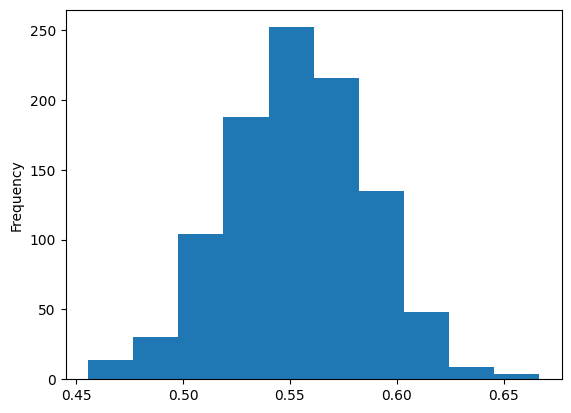

In [ ]:
# for SP500
clf_bench()

In [ ]:
persistance_clf()

The mean f1 after 10 folds cv is 0.558134995818203 with a standard deviation of 0.016358951737919354
The test f1 on 2020 is 0.4861111111111111


## 2. Classification models

### a. CNNs

In [ ]:
# source code: https://machinelearningmastery.com/using-cnn-for-financial-time-series-prediction/

# define custom metrics in Kera for f1 macro as not available directly
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 
def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

In [ ]:
# define a clf model. code leveraged on https://machinelearningmastery.com/using-cnn-for-financial-time-series-prediction/
def clf(seq_len,start_training,start_valid,end_valid,target_market_name,target_market_ticker,scale,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght):

  # 0. Apply conditions
  ## activation functions in conv layers and intializers
  if activ_func=='relu':
    activ_func = 'relu'
    initializer = 'glorot_uniform'
  elif activ_func=='leaky relu':
    activ_func = LeakyReLU()
    initializer = 'glorot_uniform'
  elif activ_func == 'selu':
    activ_func = 'selu'
    initializer = LecunNormal # LecunNormal is necessary if using SELU function
  ## pooling type
  if pool == 'average':
    pool = AveragePooling2D
  elif pool == 'max':
    pool = MaxPool2D
  ## dropout type
  if activ_func =='selu':
    drop = AlphaDropout # For SELU function the use of Alphadropout rather than Droupout is necessary
  else:
    drop = Dropout
  ## number of dense layer, number of units and active function in first dense layer
  if n_dense_layer == 2:
    activ_func_dense_1 = activ_func
  else:
    activ_func_dense_1 = 'sigmoid' # if only 1 layer, then for binary classif we need the sigmoid activation
    dense_1_units = 1
  ## regularization in weights on conv layers
  if cnn_1_kernel_regularizer:
    if reg_type=='l1':
      cnn_1_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_1_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_1_kernel_regularizer = None
  if cnn_2_kernel_regularizer:
    if reg_type=='l1':
      cnn_2_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_2_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_2_kernel_regularizer = None


  # 1. construct model
  ## Input layer
  input = Input(shape=(seq_len, n_features, 1))
  ## first cnn
  cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
  ## second cnn
  cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
  ## first pooling
  pool_1 = pool(pool_size=pool_size)(cnn_2)
  ## third cnn
  cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
  ## second pooling
  pool_2 = pool(pool_size=pool_size)(cnn_3)
  ## flattening
  flat = Flatten()(pool_2)
  ## dropout
  dropout = drop(drop_rate)(flat)
  ## first dense layer
  dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
  ## second dense layer if present
  if n_dense_layer==2:
    dense_2 = Dense(1,activation='sigmoid')(dense_1)
    model = Model(inputs=[input],outputs=[dense_2])
  else:
    model = Model(inputs=[input],outputs=[dense_1])

  # 2. compile the model
  model.compile(optimizer="adam", loss='binary_crossentropy', metrics=f1macro)

  # 3. prepare the data
  X_train, X_valid,y_train,y_valid = gen_train_test2d(seq_len,start_training,start_valid,end_valid,'Classification',target_market_name,target_market_ticker,'daily_return_+1day',scale) # daily return +1 day is not going to be used. This is just to have all parameters

  # 4. define callbacks for early stopping and model checkpoint
  early_stopping = EarlyStopping(monitor='val_f1macro',patience=40,verbose=0,mode='max') # patience of 40 if no improvement on val_f1macro stop the training
  path_model = optuna_path+'/CLF/clfv2.h5'
  model_cp = ModelCheckpoint(path_model,monitor='val_f1macro',mode='max',save_best_only=True,verbose=0) # model at epoch with the highest f1_valmacro is saved

  # 5. fit the model
  model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=n_epochs,batch_size=batch_size,verbose=0,callbacks=[early_stopping,model_cp])

  # 6. Look at results on validation set
  ## load the model at best epoch 
  model = load_model(path_model,custom_objects={"f1macro": f1macro}) # load the model corresponding to epoch with best val_f1macro
  ## predict probas
  probas_pred = model.predict(X_valid,verbose=0)
  ## use 0.5 as decision threshold
  class_pred = np.where(probas_pred>=0.5,1,0)
  ## compute f1 score macro
  f1 = f1_score(y_valid,class_pred,average='macro')

  return f1

In [ ]:
# define a clf with use of text model
def clf_text(seq_len,start_training,start_valid,end_valid,target_market_name,target_market_ticker,scale_features,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,text_data,cnn_1_text_kernel_regularizer,n_filter_1_text,n_filter_2_text,
        cnn_2_kernel_size_text,cnn_2_text_kernel_regularizer,n_filter_3_text,cnn_3_kernel_size_text,pool_size_text,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,text_dim):

  # 0. Apply conditions
  ## number of dimensions for the text and attribution of correct data for text
  if text_data=='text_v3':
    n_features_text = 768
    ### check what fold to retrieve by looking at the last validation date
    text_data = [text[3] for text in text_v3 if text[2]==end_valid][0]

  elif text_data == 'text_lex':
    n_features_text = 1
    text_data = text_lex
  else:
    n_features_text = 7
    text_data = text_loughran


  ## activation functions in conv layers and intializers
  if activ_func=='relu':
    activ_func = 'relu'
    initializer = 'glorot_uniform'
  elif activ_func=='leaky relu':
    activ_func = LeakyReLU()
    initializer = 'glorot_uniform'
  elif activ_func == 'selu':
    activ_func = 'selu'
    initializer = LecunNormal
  ## pooling type
  if pool == 'average':
    pool = AveragePooling2D
  elif pool == 'max':
    pool = MaxPool2D
  ## dropout type
  if activ_func =='selu': # have to use alphadropout with selu and not dropout
    drop = AlphaDropout
  else:
    drop = Dropout
  ## number of dense layer, number of units and active function in first dense layer
  if n_dense_layer == 2:
    activ_func_dense_1 = activ_func
  else:
    activ_func_dense_1 = 'sigmoid' # if only 1 hidden layer need sigmoid for binary classification
    dense_1_units = 1
  ## regularization in weights on conv layers
  if cnn_1_kernel_regularizer:
    if reg_type=='l1':
      cnn_1_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_1_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_1_kernel_regularizer = None
  if cnn_2_kernel_regularizer:
    if reg_type=='l1':
      cnn_2_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_2_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_2_kernel_regularizer = None
  ## regularization in weights on conv text layers
  if cnn_1_text_kernel_regularizer:
    if reg_type_text=='l1':
      cnn_1_text_kernel_regularizer = L1(reg_strenght_text)
    else:
      cnn_1_text_kernel_regularizer = L2(reg_strenght_text)
  else:
    cnn_1_text_kernel_regularizer = None
  if cnn_2_text_kernel_regularizer:
    if reg_type_text=='l1':
      cnn_2_text_kernel_regularizer = L1(reg_strenght_text)
    else:
      cnn_2_text_kernel_regularizer = L2(reg_strenght_text)
  else:
    cnn_2_text_kernel_regularizer = None

  # check if text is processed through convolutional layer first
  if text_process:
    # check if we apply a first conv layer to obtain only one feature on text
    if text_dim:
      # 1. construct model
      ## Input layers
      input = Input(shape=(seq_len, n_features, 1))
      input_text = Input(shape=(seq_len,n_features_text,1))
      ## first cnns
      cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
      cnn_1_text = Conv2D(n_filter_1_text, kernel_size=(1, n_features_text), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_text_kernel_regularizer)(input_text)
      ## second cnns
      cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
      cnn_2_text = Conv2D(n_filter_2_text, kernel_size=cnn_2_kernel_size_text, activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_2_text_kernel_regularizer)(cnn_1_text)
      ## first poolings
      pool_1 = pool(pool_size=pool_size)(cnn_2)
      pool_1_text = pool(pool_size=pool_size_text)(cnn_2_text)
      ## third cnns
      cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
      cnn_3_text = Conv2D(n_filter_3_text, kernel_size=cnn_3_kernel_size_text, activation=activ_func,kernel_initializer=initializer)(cnn_2_text)
      ## second poolings
      pool_2 = pool(pool_size=pool_size)(cnn_3)
      pool_2_text = pool(pool_size=pool_size_text)(cnn_3_text)
      ## flattening
      flat = Flatten()(pool_2)
      flat_text = Flatten()(pool_2_text)
      ## dropout
      dropout = drop(drop_rate)(flat)
      dropout_text = drop(drop_rate)(flat_text)
      ## second dense layer if present
      if n_dense_layer==2:
          ## first dense layer
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
        dense_1_text = Dense(dense_1_units_text,activation=activ_func_dense_1)(dropout_text)
        ## concatenate before second dense layer
        concat = concatenate([dense_1,dense_1_text])
        dense_2 = Dense(1,activation='sigmoid')(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_2])
      else:
        ## concatenate after flattening and drop layer
        concat = concatenate([dropout,dropout_text])
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_1])

    else:
      # 1. construct model but just one Conv layer on text for time, no conv layer on features
      ## Input layers
      input = Input(shape=(seq_len, n_features, 1))
      input_text = Input(shape=(seq_len,n_features_text,1))
      ## first cnn
      cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
      ## second cnns
      cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
      cnn_2_text = Conv2D(n_filter_2_text, kernel_size=cnn_2_kernel_size_text, activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_2_text_kernel_regularizer)(input_text)
      ## first poolings
      pool_1 = pool(pool_size=pool_size)(cnn_2)
      pool_1_text = pool(pool_size=pool_size_text)(cnn_2_text)
      ## third cnns
      cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
      cnn_3_text = Conv2D(n_filter_3_text, kernel_size=cnn_3_kernel_size_text, activation=activ_func,kernel_initializer=initializer)(cnn_2_text)
      ## second poolings
      pool_2 = pool(pool_size=pool_size)(cnn_3)
      pool_2_text = pool(pool_size=pool_size_text)(cnn_3_text)
      ## flattening
      flat = Flatten()(pool_2)
      flat_text = Flatten()(pool_2_text)
      ## dropout
      dropout = drop(drop_rate)(flat)
      dropout_text = drop(drop_rate)(flat_text)
      ## second dense layer if present
      if n_dense_layer==2:
          ## first dense layer
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
        dense_1_text = Dense(dense_1_units_text,activation=activ_func_dense_1)(dropout_text)
        ## concatenate before second dense layer
        concat = concatenate([dense_1,dense_1_text])
        dense_2 = Dense(1,activation='sigmoid')(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_2])
      else:
        ## concatenate after flattening and drop layer
        concat = concatenate([dropout,dropout_text])
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_1])

  # if text is not processed through conv layer, just flatten the text matrix before hidden layer
  else:
    # 1. construct model
    ## Input layers
    input = Input(shape=(seq_len, n_features, 1))
    input_text = Input(shape=(seq_len,n_features_text,1))
    ## first cnn
    cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
    ## second cnn
    cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
    ## first pooling
    pool_1 = pool(pool_size=pool_size)(cnn_2)
    ## third cnn
    cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
    ## second pooling
    pool_2 = pool(pool_size=pool_size)(cnn_3)
    ## flattening
    flat = Flatten()(pool_2)
    flat_text = Flatten()(input_text)
    ## dropout
    dropout = drop(drop_rate)(flat)
    dropout_text = drop(drop_rate)(flat_text)
    ## second dense layer if present
    if n_dense_layer==2:
        ## first dense layer
      dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
      dense_1_text = Dense(dense_1_units_text,activation=activ_func_dense_1)(dropout_text)
      ## concatenate before second dense layer
      concat = concatenate([dense_1,dense_1_text])
      dense_2 = Dense(1,activation='sigmoid')(concat)
      model = Model(inputs=[input,input_text],outputs=[dense_2])
    else:
      ## concatenate after flattening and drop layer
      concat = concatenate([dropout,dropout_text])
      dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(concat)
      model = Model(inputs=[input,input_text],outputs=[dense_1])




  # 2. compile the model
  model.compile(optimizer="adam", loss='binary_crossentropy', metrics=f1macro)

  # 3. prepare the data
  X_train, X_valid, text_train, text_valid, y_train, y_valid = gen_train_test2d_text(seq_len,start_training,start_valid,end_valid,'Classification',target_market_name,target_market_ticker,'daily_return_+1day',scale_features,scale_text_features,text_data)

  # 4. define callbacks for early stopping and model checkpoint
  early_stopping = EarlyStopping(monitor='val_f1macro',patience=40,verbose=0,mode='max')
  path_model = optuna_path+'/CLF/clf_textv2.h5'
  model_cp = ModelCheckpoint(path_model,monitor='val_f1macro',mode='max',save_best_only=True,verbose=0)

  # 5. fit the model
  model.fit((X_train,text_train),y_train,validation_data=((X_valid,text_valid),y_valid),epochs=n_epochs,batch_size=batch_size,verbose=0,callbacks=[early_stopping,model_cp])

  # 6. Look at results on validation set
  ## load the model at best epoch 
  model = load_model(path_model,custom_objects={"f1macro": f1macro})
  ## predict probas
  probas_pred = model.predict((X_valid,text_valid),verbose=0)
  ## use 0.5 as decision threshold
  class_pred = np.where(probas_pred>=0.5,1,0)
  ## compute f1 score macro
  f1 = f1_score(y_valid,class_pred,average='macro')

  return f1

In [ ]:
# define objective function for SP500 clf
def objective_sp500_clf(trial):
  # save the study
  joblib.dump(study_clf,optuna_path+'/CLF/clf_study.pkl')

  # 0. Hard coded parameter
  target_market_name = 'SP500'
  target_market_ticker = '^GSPC'
  n_features = 73
  n_epochs = 400

  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'activ_func':[],'n_filter_1':[],'n_filter_2':[],'cnn_2_kernel_size':[],'pool':[],'n_filter_3':[],'cnn_3_kernel_size':[],'pool_size':[],'drop_rate':[],'n_dense_layer':[],
             'dense_1_units':[],'batch_size':[],'cnn_1_kernel_regularizer':[],'cnn_2_kernel_regularizer':[],'scale':[],'reg_type':[],'reg_strenght':[],'f1_mean':[],'f1_std':[]}

  ## Optuna chooses
  seq_len = trial.suggest_int('seq_len',30,80,5)
  results['seq_len'].append(seq_len)

  activ_func = trial.suggest_categorical('activ_func',['relu','leaky relu','selu'])
  results['activ_func'].append(activ_func)

  n_filter_1 = trial.suggest_int('n_filter_1',3,12,1)
  results['n_filter_1'].append(n_filter_1)

  n_filter_2 = trial.suggest_int('n_filter_2',4,25,1)
  results['n_filter_2'].append(n_filter_2)

  cnn_2_kernel_size = (trial.suggest_int('cnn_2_kernel_size',2,8,1),1)
  results['cnn_2_kernel_size'].append(cnn_2_kernel_size)

  pool = trial.suggest_categorical('pool',['average','max'])
  results['pool'].append(pool)

  n_filter_3 = trial.suggest_int('n_filter_3',5,40,1)
  results['n_filter_3'].append(n_filter_3)
  
  cnn_3_kernel_size = (trial.suggest_int('cnn_3_kernel_size',2,8,1),1)
  results['cnn_3_kernel_size'].append(cnn_3_kernel_size)

  pool_size = (trial.suggest_int('pool_size',2,5,1),1)
  results['pool_size'].append(pool_size)

  drop_rate = trial.suggest_float('drop_rate',0.1,0.6,step=0.05)
  results['drop_rate'].append(drop_rate)

  n_dense_layer =  trial.suggest_int('n_dense_layer',1,2,1)
  results['n_dense_layer'].append(n_dense_layer)

  if n_dense_layer == 2:
    dense_1_units = trial.suggest_int('dense_1_units',10,100,10)
    results['dense_1_units'].append(dense_1_units)
  else:
    dense_1_units = 1
    results['dense_1_units'].append(1)

  batch_size = trial.suggest_categorical('batch_size',[32,65,128,256])
  results['batch_size'].append(batch_size)

  cnn_1_kernel_regularizer = trial.suggest_categorical('cnn_1_kernel_regularizer',[True,False])
  results['cnn_1_kernel_regularizer'].append(cnn_1_kernel_regularizer)

  cnn_2_kernel_regularizer = trial.suggest_categorical('cnn_2_kernel_regularizer',[True,False])
  results['cnn_2_kernel_regularizer'].append(cnn_2_kernel_regularizer)

  # if we have a l1 or l2 regularization on the weights of conv layer, need to scale the features
  if (cnn_1_kernel_regularizer or cnn_2_kernel_regularizer):
    scale = True
    reg_type =  trial.suggest_categorical('reg_type',['l1','l2'])
    reg_strenght = trial.suggest_float('reg_strenght',0.0001,0.01,step=0.0001)
  else:
    # if no l1 or l2 we can choose to scale or not
    scale = trial.suggest_categorical('scale',[True,False])
    reg_type = None
    reg_strenght = None

  results['scale'].append(scale)
  results['reg_type'].append(reg_type)
  results['reg_strenght'].append(reg_strenght)

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  f1 = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    f1_score = clf(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,scale,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght)
    
    f1.append(f1_score)

  f1_mean = np.mean(f1)
  results['f1_mean'].append(f1_mean)
  f1_std = np.std(f1)
  results['f1_std'].append(f1_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a clf_result df in folder load an append the line
  if os.path.isfile(optuna_path+'/CLF/clf_result.pkl'):
    df = pd.read_pickle(optuna_path+'/CLF/clf_result.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/CLF/clf_result.pkl')

  # return the mean of cross validated f1 for the given model choices
  return f1_mean

In [ ]:
# define objective function for SP500 clf with use of text
def objective_sp500_text_clf(trial):
  # save the study
  joblib.dump(study_text_clf,optuna_path+'/CLF/clf_text_study.pkl')

  # 0. Hard coded parameter
  target_market_name = 'SP500'
  target_market_ticker = '^GSPC'
  n_features = 73
  n_epochs = 400
  

  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'scale_features':[],'activ_func':[],'n_filter_1':[],'n_filter_2':[],'cnn_2_kernel_size':[],'pool':[],'n_filter_3':[],'cnn_3_kernel_size':[],
        'pool_size':[],'drop_rate':[],'n_dense_layer':[],'dense_1_units':[],'batch_size':[],'cnn_1_kernel_regularizer':[],'cnn_2_kernel_regularizer':[],'reg_type':[],
        'reg_strenght':[],'text_data':[],'cnn_1_text_kernel_regularizer':[],'n_filter_1_text':[],'n_filter_2_text':[],'cnn_2_kernel_size_text':[],
        'cnn_2_text_kernel_regularizer':[],'n_filter_3_text':[],'cnn_3_kernel_size_text':[],'pool_size_text':[],'dense_1_units_text':[],'scale_text_features':[],
        'reg_type_text':[],'reg_strenght_text':[],'text_process':[],'text_dim':[],'f1_mean':[],'f1_std':[]}

  ## Optuna chooses
  ### choses first what text data we use
  text_data = trial.suggest_categorical('text_data',['text_v3','text_lex','text_lough'])
  results['text_data'].append(text_data)

  ### if text data is 'text_lex' there is only one text feature, so no conv layer on text dim
  if text_data == 'text_lex':
    text_dim = False
  else:
    # otherwise we can chose
    text_dim = trial.suggest_categorical('text_dim',[True,False])
  results['text_dim'].append(text_dim)
  
  ### chose if we process text through conv layer or just flatten
  text_process =  trial.suggest_categorical('text_process',[True,False])
  results['text_process'].append(text_process)

  seq_len = trial.suggest_int('seq_len',30,80,5)
  results['seq_len'].append(seq_len)

  activ_func = trial.suggest_categorical('activ_func',['relu','leaky relu','selu'])
  results['activ_func'].append(activ_func)

  n_filter_1 = trial.suggest_int('n_filter_1',3,12,1)
  results['n_filter_1'].append(n_filter_1)

  ### below parameters choice depend if we process the text through conv layer and if we put one on text dimensions
  if text_process:
    if text_dim:
      n_filter_1_text = trial.suggest_int('n_filter_1_text',3,12,1)
      results['n_filter_1_text'].append(n_filter_1_text)
    else:
      results['n_filter_1_text'].append('NA')
      n_filter_1_text = None
  else:
    n_filter_1_text = None
    results['n_filter_1_text'].append('NA')

  n_filter_2 = trial.suggest_int('n_filter_2',4,25,1)
  results['n_filter_2'].append(n_filter_2)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    n_filter_2_text = trial.suggest_int('n_filter_2_text',4,25,1)
    results['n_filter_2_text'].append(n_filter_2_text)
  else:
    results['n_filter_2_text'].append('NA')
    n_filter_2_text = None

  cnn_2_kernel_size = (trial.suggest_int('cnn_2_kernel_size',2,8,1),1)
  results['cnn_2_kernel_size'].append(cnn_2_kernel_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_2_kernel_size_text = (trial.suggest_int('cnn_2_kernel_size_text',2,8,1),1)
    results['cnn_2_kernel_size_text'].append(cnn_2_kernel_size_text)
  else:
    results['cnn_2_kernel_size_text'].append('NA')
    cnn_2_kernel_size_text = None


  pool = trial.suggest_categorical('pool',['average','max'])
  results['pool'].append(pool)

  n_filter_3 = trial.suggest_int('n_filter_3',5,40,1)
  results['n_filter_3'].append(n_filter_3)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    n_filter_3_text = trial.suggest_int('n_filter_3_text',5,40,1)
    results['n_filter_3_text'].append(n_filter_3_text)
  else:
    results['n_filter_3_text'].append('NA')
    n_filter_3_text = None

  
  cnn_3_kernel_size = (trial.suggest_int('cnn_3_kernel_size',2,8,1),1)
  results['cnn_3_kernel_size'].append(cnn_3_kernel_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_3_kernel_size_text = (trial.suggest_int('cnn_3_kernel_size_text',2,8,1),1)
    results['cnn_3_kernel_size_text'].append(cnn_3_kernel_size_text)
  else:
    results['cnn_3_kernel_size_text'].append('NA')
    cnn_3_kernel_size_text = None

  pool_size = (trial.suggest_int('pool_size',2,5,1),1)
  results['pool_size'].append(pool_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    pool_size_text = (trial.suggest_int('pool_size_text',2,5,1),1)
    results['pool_size_text'].append(pool_size_text)
  else:
    results['pool_size_text'].append('NA')
    pool_size_text = None


  drop_rate = trial.suggest_float('drop_rate',0.1,0.6,step=0.05)
  results['drop_rate'].append(drop_rate)

  n_dense_layer =  trial.suggest_int('n_dense_layer',1,2,1)
  results['n_dense_layer'].append(n_dense_layer)

  if n_dense_layer == 2:
    dense_1_units = trial.suggest_int('dense_1_units',10,100,10)
    dense_1_units_text = trial.suggest_int('dense_1_units_text',10,100,10)
    results['dense_1_units'].append(dense_1_units)
    results['dense_1_units_text'].append(dense_1_units_text)
  else:
    dense_1_units = 1
    dense_1_units_text = 1
    results['dense_1_units'].append(1)
    results['dense_1_units_text'].append(1)

  batch_size = trial.suggest_categorical('batch_size',[32,65,128,256])
  results['batch_size'].append(batch_size)

  cnn_1_kernel_regularizer = trial.suggest_categorical('cnn_1_kernel_regularizer',[True,False])
  results['cnn_1_kernel_regularizer'].append(cnn_1_kernel_regularizer)

  ## below parameters choice depend if we process the text through conv layer and put a layer on text dimensions
  if text_process:
    if text_dim:
      cnn_1_text_kernel_regularizer = trial.suggest_categorical('cnn_1_text_kernel_regularizer',[True,False])
      results['cnn_1_text_kernel_regularizer'].append(cnn_1_text_kernel_regularizer)
    else:
      cnn_1_text_kernel_regularizer = None
      results['cnn_1_text_kernel_regularizer'].append('NA')

  else:
    results['cnn_1_text_kernel_regularizer'].append('NA')
    cnn_1_text_kernel_regularizer = None


  cnn_2_kernel_regularizer = trial.suggest_categorical('cnn_2_kernel_regularizer',[True,False])
  results['cnn_2_kernel_regularizer'].append(cnn_2_kernel_regularizer)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_2_text_kernel_regularizer = trial.suggest_categorical('cnn_2_text_kernel_regularizer',[True,False])
    results['cnn_2_text_kernel_regularizer'].append(cnn_2_text_kernel_regularizer)
  else:
    results['cnn_2_text_kernel_regularizer'].append('NA')
    cnn_2_text_kernel_regularizer = None

  ## if we use l1 or l2 we need to scale the features
  if (cnn_1_kernel_regularizer or cnn_2_kernel_regularizer):
    scale_features = True
    reg_type =  trial.suggest_categorical('reg_type',['l1','l2'])
    reg_strenght = trial.suggest_float('reg_strenght',0.0001,0.01,step=0.0001)
  else:
    ## otherwise can choose
    scale_features = trial.suggest_categorical('scale_features',[True,False])
    reg_type = None
    reg_strenght = None

  results['scale_features'].append(scale_features)
  results['reg_type'].append(reg_type)
  results['reg_strenght'].append(reg_strenght)

  ## if we use l1 or l2 we need to scale the features
  if text_process:
    if (cnn_1_text_kernel_regularizer or cnn_2_text_kernel_regularizer):
      scale_text_features = True
      reg_type_text =  trial.suggest_categorical('reg_type_text',['l1','l2'])
      reg_strenght_text = trial.suggest_float('reg_strenght_text',0.0001,0.01,step=0.0001)
    else:
      scale_text_features = trial.suggest_categorical('scale_text_features',[True,False])
      reg_type_text = None
      reg_strenght_text = None

    results['scale_text_features'].append(scale_text_features)
    results['reg_type_text'].append(reg_type_text)
    results['reg_strenght_text'].append(reg_strenght_text)
  else:
    results['scale_text_features'].append('NA')
    results['reg_type_text'].append('NA')
    results['reg_strenght_text'].append('NA')
    scale_text_features = None
    reg_type_text = None
    reg_strenght_text = None

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  f1 = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    f1_score = clf_text(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,scale_features,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,text_data,cnn_1_text_kernel_regularizer,n_filter_1_text,n_filter_2_text,
        cnn_2_kernel_size_text,cnn_2_text_kernel_regularizer,n_filter_3_text,cnn_3_kernel_size_text,pool_size_text,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,text_dim)
    
    f1.append(f1_score)

  f1_mean = np.mean(f1)
  results['f1_mean'].append(f1_mean)
  f1_std = np.std(f1)
  results['f1_std'].append(f1_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a clf_result df in folder load an append the line
  if os.path.isfile(optuna_path+'/CLF/clf_text_result.pkl'):
    df = pd.read_pickle(optuna_path+'/CLF/clf_text_result.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/CLF/clf_text_result.pkl')

  # return the mean of cross validated f1 for the given model choices
  return f1_mean

### b. Catboost

In [ ]:
def cb_clf(seq_len,start_training,start_valid,end_valid,target_market_name,target_market_ticker,
           learning_rate,depth,l2_leaf_reg):
  # 1. prepare the data
  X_train,X_valid,y_train,y_valid = gen_train_test_tab(seq_len,start_training,start_valid,end_valid,'Classification',target_market_name,target_market_ticker,scale=False)

  # 2. Instantiate model
  cb_clf = CatBoostClassifier(random_seed=42,eval_metric='TotalF1:average=Macro',task_type='GPU',learning_rate=learning_rate,depth=depth,l2_leaf_reg=l2_leaf_reg)

  # 3. Identify categorical features which are the day and convert to int
  cat_features = [c for c in X_train.columns if 'Day' in c]
  X_train[cat_features] = X_train[cat_features].astype(int)
  X_valid[cat_features] = X_valid[cat_features].astype(int)
  
  # 4. Fit
  cb_clf.fit(X_train,y_train,cat_features=cat_features,eval_set=(X_valid,y_valid),early_stopping_rounds=40,verbose=0)

  # 5. predict
  preds = cb_clf.predict(X_valid)

  # 6. compute f1 macro
  f1 = f1_score(y_valid,preds,average='macro')

  return f1

In [ ]:
def objective_sp500_clf_cb(trial):
  # save the study
  joblib.dump(study_clf_cb,optuna_path+'/CLF/clf_study_cb.pkl')

  # 0. Hardcoded
  target_market_name,target_market_ticker = 'SP500','^GSPC'
  
  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'learning_rate':[],'depth':[],'l2_leaf_reg':[],'f1_mean':[],'f1_std':[]}

  ## Optuna chooses
  ### choses first the sequence lenght
  # seq_len = trial.suggest_int('seq_len',0,10,1)
  seq_len = 0
  results['seq_len'].append(seq_len)

  ### choses the learning rate
  learning_rate = trial.suggest_float('learning_rate',low=0.001,high=0.1,step=0.001)
  results['learning_rate'].append(learning_rate)

  ### choses the depth of trees
  depth = trial.suggest_int('depth',2,10,1)
  results['depth'].append(depth)

  ### choses the l2_leaf_reg
  l2_leaf_reg = trial.suggest_int('l2_leaf_reg',0,30,1)
  results['l2_leaf_reg'].append(l2_leaf_reg)

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  f1 = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    f1_score = cb_clf(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,learning_rate,depth,l2_leaf_reg)
    f1.append(f1_score)

  f1_mean = np.mean(f1)
  results['f1_mean'].append(f1_mean)
  f1_std = np.std(f1)
  results['f1_std'].append(f1_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a clf_result df in folder load an append the line
  if os.path.isfile(optuna_path+'/CLF/clf_cb_result.pkl'):
    df = pd.read_pickle(optuna_path+'/CLF/clf_cb_result.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/CLF/clf_cb_result.pkl')

  # return the mean of cross validated f1 for the given model choices
  return f1_mean

  

In [ ]:
def cb_clf_text(seq_len,start_training,start_valid,end_valid,target_market_name,target_market_ticker,text_data,text_dim,
                learning_rate,depth,l2_leaf_reg):
  # 1. Retrieve text

  if text_data=='text_v3':
    ### check what fold to retrieve by looking at the last validation date
    text_data = [text[3] for text in text_v3 if text[2]==end_valid][0]

  elif text_data == 'text_lex':
    text_data = text_lex
  else:
    text_data = text_loughran

  # 2. prepare the data
  X_train,X_valid,y_train,y_valid = gen_train_test_text_tab(seq_len,start_training,start_valid,end_valid,'Classification',target_market_name,target_market_ticker,scale_features=False,text_data=text_data)

  # 3. PCA on text_v3 (dimension is 768 we will run out of memory)
  if text_data.shape[1]==768:
    # instantiate PCA
    pca = PCA(n_components=text_dim)
    # select text features
    text_features = [c for c in X_train.columns if 'text' in c]
    # fit PCA
    pca.fit(X_train[text_features])
    # get new text features for train and valid
    X_train_reduced_text = pd.DataFrame(pca.transform(X_train[text_features]),columns=['text_comp_'+str(i) for i in range(text_dim)],index=X_train.index)
    X_valid_reduced_text = pd.DataFrame(pca.transform(X_valid[text_features]),columns=['text_comp_'+str(i) for i in range(text_dim)],index=X_valid.index)
    # get rid of original text features and replace by new text features in reduced dimension
    X_train.drop(labels=text_features,axis=1,inplace=True)
    X_valid.drop(labels=text_features,axis=1,inplace=True)
    X_train = pd.concat([X_train,X_train_reduced_text],axis=1)
    X_valid = pd.concat([X_valid,X_valid_reduced_text],axis=1)




  # 4. Instantiate model
  cb_clf = CatBoostClassifier(random_seed=42,eval_metric='TotalF1:average=Macro',task_type='GPU',learning_rate=learning_rate,depth=depth,l2_leaf_reg=l2_leaf_reg)

  # 5. Identify categorical features which are the day and convert to int
  cat_features = [c for c in X_train.columns if 'Day' in c]
  X_train[cat_features] = X_train[cat_features].astype(int)
  X_valid[cat_features] = X_valid[cat_features].astype(int)
  
  # 6. Fit
  cb_clf.fit(X_train,y_train,cat_features=cat_features,eval_set=(X_valid,y_valid),early_stopping_rounds=40,verbose=0)

  # 7. predict
  preds = cb_clf.predict(X_valid)

  # 8. compute f1 macro
  f1 = f1_score(y_valid,preds,average='macro')

  return f1

In [ ]:
def objective_sp500_clf_text_cb(trial):
  # save the study
  joblib.dump(study_clf_cb,optuna_path+'/CLF/clf_study_text_cb.pkl')

  # 0. Hardcoded
  target_market_name,target_market_ticker = 'SP500','^GSPC'
  
  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'learning_rate':[],'depth':[],'text_data':[],'text_dim':[],'l2_leaf_reg':[],'f1_mean':[],'f1_std':[]}

  ## Optuna chooses
  ### choses first the sequence lenght
  # seq_len = trial.suggest_int('seq_len',0,10,1)
  seq_len = 0
  results['seq_len'].append(seq_len)

  ### choses the learning rate
  learning_rate = trial.suggest_float('learning_rate',low=0.001,high=0.1,step=0.001)
  results['learning_rate'].append(learning_rate)

  ### choses the depth of trees
  depth = trial.suggest_int('depth',2,10,1)
  results['depth'].append(depth)

  ### choses the l2_leaf_reg
  l2_leaf_reg = trial.suggest_int('l2_leaf_reg',0,30,1)
  results['l2_leaf_reg'].append(l2_leaf_reg)

  ### choses the text
  text_data = trial.suggest_categorical('text_data',['text_v3','text_lex','text_lough'])
  results['text_data'].append(text_data)
  ### if text_v3 is chosen choses the nber of components to retain for PCA
  if text_data=='text_v3':
    text_dim = trial.suggest_int('text_dim',2,30,1)
    results['text_dim'].append(text_dim)
  else:
    text_dim = 'NA'
    results['text_dim'].append('NA')


  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  f1 = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    f1_score = cb_clf_text(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,text_data,text_dim,learning_rate,depth,l2_leaf_reg)
    f1.append(f1_score)

  f1_mean = np.mean(f1)
  results['f1_mean'].append(f1_mean)
  f1_std = np.std(f1)
  results['f1_std'].append(f1_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a clf_result df in folder load an append the line
  if os.path.isfile(optuna_path+'/CLF/clf_cb_text_result.pkl'):
    df = pd.read_pickle(optuna_path+'/CLF/clf_cb_text_result.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/CLF/clf_cb_text_result.pkl')

  # return the mean of cross validated f1 for the given model choices
  return f1_mean

## 3. Regression models

In [ ]:
# define a regression model
def reg(seq_len,start_training,start_valid,end_valid,target_market_name,target_market_ticker,scale,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,monitor):

  # 0. Apply conditions
  ## monitor mae or rmse on val set
  if monitor=='mae':
    monitor='val_mae'
    loss = 'mae'
  else:
    monitor='val_root_mean_squared_error'
    loss = 'mse'
  ## activation functions in conv layers and intializers
  if activ_func=='relu':
    activ_func = 'relu'
    initializer = 'glorot_uniform'
  elif activ_func=='leaky relu':
    activ_func = LeakyReLU()
    initializer = 'glorot_uniform'
  elif activ_func == 'selu':
    activ_func = 'selu'
    initializer = LecunNormal
  ## pooling type
  if pool == 'average':
    pool = AveragePooling2D
  elif pool == 'max':
    pool = MaxPool2D
  ## dropout type
  if activ_func =='selu':
    drop = AlphaDropout
  else:
    drop = Dropout
  ## number of dense layer, number of units and active function in first dense layer
  if n_dense_layer == 2:
    activ_func_dense_1 = activ_func
  else:
    activ_func_dense_1 = None
    dense_1_units = 1
  ## regularization in weights on conv layers
  if cnn_1_kernel_regularizer:
    if reg_type=='l1':
      cnn_1_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_1_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_1_kernel_regularizer = None
  if cnn_2_kernel_regularizer:
    if reg_type=='l1':
      cnn_2_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_2_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_2_kernel_regularizer = None


  # 1. construct model
  ## Input layer
  input = Input(shape=(seq_len, n_features, 1))
  ## first cnn
  cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
  ## second cnn
  cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
  ## first pooling
  pool_1 = pool(pool_size=pool_size)(cnn_2)
  ## third cnn
  cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
  ## second pooling
  pool_2 = pool(pool_size=pool_size)(cnn_3)
  ## flattening
  flat = Flatten()(pool_2)
  ## dropout
  dropout = drop(drop_rate)(flat)
  ## first dense layer
  dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
  ## second dense layer if present
  if n_dense_layer==2:
    dense_2 = Dense(1,activation=None)(dense_1)
    model = Model(inputs=[input],outputs=[dense_2])
  else:
    model = Model(inputs=[input],outputs=[dense_1])

  # 2. compile the model
  model.compile(optimizer="adam", loss=loss, metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])

  # 3. prepare the data
  X_train, X_valid,y_train,y_valid = gen_train_test2d(seq_len,start_training,start_valid,end_valid,'Regression',target_market_name,target_market_ticker,'daily_return_+1day',scale)

  # 4. define callbacks for early stopping and model checkpoint
  early_stopping = EarlyStopping(monitor= monitor,patience=40,verbose=0,mode='min')
  path_model = optuna_path+'/Reg/reg'+f'_{monitor}.h5'
  model_cp = ModelCheckpoint(path_model,monitor=monitor,mode='min',save_best_only=True,verbose=0)

  # 5. fit the model
  model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=n_epochs,batch_size=batch_size,verbose=0,callbacks=[early_stopping,model_cp])

  # 6. Look at results on validation set
  ## load the model at best epoch 
  model = load_model(path_model)
  ## predict returns
  ret_pred = model.predict(X_valid,verbose=0)
  ## get price data
  _, _, _, y_valid_price = gen_train_test2d(seq_len,start_training,start_valid,end_valid,'Regression',target_market_name,target_market_ticker,'close_+1day',scale)
  ## compute price predictions based on previous real price and predicted return  
  price_pred = []
  for tup in zip(list(y_valid_price[:-1]),list(ret_pred[1:])):
    price_pred.append(tup[0]*(1+tup[1][0]))
  mae = mean_absolute_error(y_valid_price[1:],price_pred)
  rmse = mean_squared_error(y_valid_price[1:],price_pred)**0.5

  return mae,rmse

In [ ]:
# define regression model with use of text
def reg_text(seq_len,start_training,start_valid,end_valid,target_market_name,target_market_ticker,scale_features,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,text_data,cnn_1_text_kernel_regularizer,n_filter_1_text,n_filter_2_text,
        cnn_2_kernel_size_text,cnn_2_text_kernel_regularizer,n_filter_3_text,cnn_3_kernel_size_text,pool_size_text,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,monitor,text_dim):

  # 0. Apply conditions
  ## number of dimensions for the text and attribution of correct data for text
  if text_data=='text_v3':
    n_features_text = 768
    ### check what fold to retrieve by looking at the last validation date
    text_data = [text[3] for text in text_v3 if text[2]==end_valid][0]

  elif text_data == 'text_lex':
    n_features_text = 1
    text_data = text_lex
  else:
    n_features_text = 7
    text_data = text_loughran

  ## monitor mae or rmse on val set
  if monitor=='mae':
    monitor='val_mae'
    loss = 'mae'
  else:
    monitor='val_root_mean_squared_error'
    loss = 'mse'
  ## activation functions in conv layers and intializers
  if activ_func=='relu':
    activ_func = 'relu'
    initializer = 'glorot_uniform'
  elif activ_func=='leaky relu':
    activ_func = LeakyReLU()
    initializer = 'glorot_uniform'
  elif activ_func == 'selu':
    activ_func = 'selu'
    initializer = LecunNormal
  ## pooling type
  if pool == 'average':
    pool = AveragePooling2D
  elif pool == 'max':
    pool = MaxPool2D
  ## dropout type
  if activ_func =='selu':
    drop = AlphaDropout
  else:
    drop = Dropout
  ## number of dense layer, number of units and active function in first dense layer
  if n_dense_layer == 2:
    activ_func_dense_1 = activ_func
  else:
    activ_func_dense_1 = None
    dense_1_units = 1
  ## regularization in weights on conv layers
  if cnn_1_kernel_regularizer:
    if reg_type=='l1':
      cnn_1_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_1_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_1_kernel_regularizer = None
  if cnn_2_kernel_regularizer:
    if reg_type=='l1':
      cnn_2_kernel_regularizer = L1(reg_strenght)
    else:
      cnn_2_kernel_regularizer = L2(reg_strenght)
  else:
    cnn_2_kernel_regularizer = None
  ## regularization in weights on conv text layers
  if cnn_1_text_kernel_regularizer:
    if reg_type_text=='l1':
      cnn_1_text_kernel_regularizer = L1(reg_strenght_text)
    else:
      cnn_1_text_kernel_regularizer = L2(reg_strenght_text)
  else:
    cnn_1_text_kernel_regularizer = None
  if cnn_2_text_kernel_regularizer:
    if reg_type_text=='l1':
      cnn_2_text_kernel_regularizer = L1(reg_strenght_text)
    else:
      cnn_2_text_kernel_regularizer = L2(reg_strenght_text)
  else:
    cnn_2_text_kernel_regularizer = None

  if text_process:
    # if a conv layer is put on text dimensions
    if text_dim:
      # 1. construct model
      ## Input layers
      input = Input(shape=(seq_len, n_features, 1))
      input_text = Input(shape=(seq_len,n_features_text,1))
      ## first cnns
      cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
      cnn_1_text = Conv2D(n_filter_1_text, kernel_size=(1, n_features_text), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_text_kernel_regularizer)(input_text)
      ## second cnns
      cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
      cnn_2_text = Conv2D(n_filter_2_text, kernel_size=cnn_2_kernel_size_text, activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_2_text_kernel_regularizer)(cnn_1_text)
      ## first poolings
      pool_1 = pool(pool_size=pool_size)(cnn_2)
      pool_1_text = pool(pool_size=pool_size_text)(cnn_2_text)
      ## third cnns
      cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
      cnn_3_text = Conv2D(n_filter_3_text, kernel_size=cnn_3_kernel_size_text, activation=activ_func,kernel_initializer=initializer)(cnn_2_text)
      ## second poolings
      pool_2 = pool(pool_size=pool_size)(cnn_3)
      pool_2_text = pool(pool_size=pool_size_text)(cnn_3_text)
      ## flattening
      flat = Flatten()(pool_2)
      flat_text = Flatten()(pool_2_text)
      ## dropout
      dropout = drop(drop_rate)(flat)
      dropout_text = drop(drop_rate)(flat_text)
      ## second dense layer if present
      if n_dense_layer==2:
          ## first dense layer
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
        dense_1_text = Dense(dense_1_units_text,activation=activ_func_dense_1)(dropout_text)
        ## concatenate before second dense layer
        concat = concatenate([dense_1,dense_1_text])
        dense_2 = Dense(1,activation=None)(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_2])
      else:
        ## concatenate after flattening and drop layer
        concat = concatenate([dropout,dropout_text])
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_1])

    # otherwize just on conv layer on time dimension of text features
    else:
      # 1. construct model
      ## Input layers
      input = Input(shape=(seq_len, n_features, 1))
      input_text = Input(shape=(seq_len,n_features_text,1))
      ## first cnn
      cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
      ## second cnns
      cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
      cnn_2_text = Conv2D(n_filter_2_text, kernel_size=cnn_2_kernel_size_text, activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_2_text_kernel_regularizer)(input_text)
      ## first poolings
      pool_1 = pool(pool_size=pool_size)(cnn_2)
      pool_1_text = pool(pool_size=pool_size_text)(cnn_2_text)
      ## third cnns
      cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
      cnn_3_text = Conv2D(n_filter_3_text, kernel_size=cnn_3_kernel_size_text, activation=activ_func,kernel_initializer=initializer)(cnn_2_text)
      ## second poolings
      pool_2 = pool(pool_size=pool_size)(cnn_3)
      pool_2_text = pool(pool_size=pool_size_text)(cnn_3_text)
      ## flattening
      flat = Flatten()(pool_2)
      flat_text = Flatten()(pool_2_text)
      ## dropout
      dropout = drop(drop_rate)(flat)
      dropout_text = drop(drop_rate)(flat_text)
      ## second dense layer if present
      if n_dense_layer==2:
          ## first dense layer
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
        dense_1_text = Dense(dense_1_units_text,activation=activ_func_dense_1)(dropout_text)
        ## concatenate before second dense layer
        concat = concatenate([dense_1,dense_1_text])
        dense_2 = Dense(1,activation=None)(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_2])
      else:
        ## concatenate after flattening and drop layer
        concat = concatenate([dropout,dropout_text])
        dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(concat)
        model = Model(inputs=[input,input_text],outputs=[dense_1])

  # if no text processing just flatten text matrix before hidden layer
  else:
    # 1. construct model
    ## Input layers
    input = Input(shape=(seq_len, n_features, 1))
    input_text = Input(shape=(seq_len,n_features_text,1))
    ## first cnn
    cnn_1 = Conv2D(n_filter_1, kernel_size=(1, n_features), activation=activ_func,kernel_initializer=initializer,kernel_regularizer=cnn_1_kernel_regularizer)(input)
    ## second cnn
    cnn_2 = Conv2D(n_filter_2, kernel_size=cnn_2_kernel_size, activation=activ_func,kernel_initializer=initializer,kernel_regularizer= cnn_2_kernel_regularizer)(cnn_1)
    ## first pooling
    pool_1 = pool(pool_size=pool_size)(cnn_2)
    ## third cnn
    cnn_3 = Conv2D(n_filter_3, kernel_size=cnn_3_kernel_size, activation=activ_func,kernel_initializer=initializer)(cnn_2)
    ## second pooling
    pool_2 = pool(pool_size=pool_size)(cnn_3)
    ## flattening
    flat = Flatten()(pool_2)
    flat_text = Flatten()(input_text)
    ## dropout
    dropout = drop(drop_rate)(flat)
    dropout_text = drop(drop_rate)(flat_text)
    ## second dense layer if present
    if n_dense_layer==2:
        ## first dense layer
      dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(dropout)
      dense_1_text = Dense(dense_1_units_text,activation=activ_func_dense_1)(dropout_text)
      ## concatenate before second dense layer
      concat = concatenate([dense_1,dense_1_text])
      dense_2 = Dense(1,activation=None)(concat)
      model = Model(inputs=[input,input_text],outputs=[dense_2])
    else:
      ## concatenate after flattening and drop layer
      concat = concatenate([dropout,dropout_text])
      dense_1 = Dense(dense_1_units,activation=activ_func_dense_1)(concat)
      model = Model(inputs=[input,input_text],outputs=[dense_1])




  # 2. compile the model
  model.compile(optimizer="adam", loss=loss, metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])

  # 3. prepare the data
  X_train, X_valid, text_train, text_valid, y_train, y_valid = gen_train_test2d_text(seq_len,start_training,start_valid,end_valid,'Regression',target_market_name,target_market_ticker,'daily_return_+1day',scale_features,scale_text_features,text_data)

  # 4. define callbacks for early stopping and model checkpoint
  early_stopping = EarlyStopping(monitor=monitor,patience=40,verbose=0,mode='min')
  path_model = optuna_path+'/Reg/reg'+f'_{monitor}.h5'
  model_cp = ModelCheckpoint(path_model,monitor=monitor,mode='min',save_best_only=True,verbose=0)

  # 5. fit the model
  model.fit((X_train,text_train),y_train,validation_data=((X_valid,text_valid),y_valid),epochs=n_epochs,batch_size=batch_size,verbose=0,callbacks=[early_stopping,model_cp])

  # 6. Look at results on validation set
  ## load the model at best epoch 
  model = load_model(path_model)
  ## predict returns
  ret_pred = model.predict((X_valid,text_valid),verbose=0)
  ## get price data
  _, _, _, y_valid_price = gen_train_test2d(seq_len,start_training,start_valid,end_valid,'Regression',target_market_name,target_market_ticker,'close_+1day',scale=False) # doesn't matter for scale we just retrieve close price
  ## compute price predictions based on previous real price and predicted return  
  price_pred = []
  for tup in zip(list(y_valid_price[:-1]),list(ret_pred[1:])):
    price_pred.append(tup[0]*(1+tup[1][0]))
  mae = mean_absolute_error(y_valid_price[1:],price_pred)
  rmse = mean_squared_error(y_valid_price[1:],price_pred)**0.5

  return mae,rmse

In [ ]:
# define objective function for SP500 regression tuned for mae
def objective_sp500_reg_mae(trial):
  # save the study
  joblib.dump(study_reg_mae,optuna_path+'/Reg/reg_study_mae.pkl')

  # 0. Hard coded parameter
  target_market_name = 'SP500'
  target_market_ticker = '^GSPC'
  n_features = 73
  n_epochs = 400
  monitor = 'mae'

  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'activ_func':[],'n_filter_1':[],'n_filter_2':[],'cnn_2_kernel_size':[],'pool':[],'n_filter_3':[],'cnn_3_kernel_size':[],'pool_size':[],'drop_rate':[],'n_dense_layer':[],
             'dense_1_units':[],'batch_size':[],'cnn_1_kernel_regularizer':[],'cnn_2_kernel_regularizer':[],'scale':[],'reg_type':[],'reg_strenght':[],'mae_mean':[],'mae_std':[],'rmse_mean':[],'rmse_std':[]}

  ## Optuna chooses
  seq_len = trial.suggest_int('seq_len',30,80,5)
  results['seq_len'].append(seq_len)

  activ_func = trial.suggest_categorical('activ_func',['relu','leaky relu','selu'])
  results['activ_func'].append(activ_func)

  n_filter_1 = trial.suggest_int('n_filter_1',3,12,1)
  results['n_filter_1'].append(n_filter_1)

  n_filter_2 = trial.suggest_int('n_filter_2',4,25,1)
  results['n_filter_2'].append(n_filter_2)

  cnn_2_kernel_size = (trial.suggest_int('cnn_2_kernel_size',2,8,1),1)
  results['cnn_2_kernel_size'].append(cnn_2_kernel_size)

  pool = trial.suggest_categorical('pool',['average','max'])
  results['pool'].append(pool)

  n_filter_3 = trial.suggest_int('n_filter_3',5,40,1)
  results['n_filter_3'].append(n_filter_3)
  
  cnn_3_kernel_size = (trial.suggest_int('cnn_3_kernel_size',2,8,1),1)
  results['cnn_3_kernel_size'].append(cnn_3_kernel_size)

  pool_size = (trial.suggest_int('pool_size',2,5,1),1)
  results['pool_size'].append(pool_size)

  drop_rate = trial.suggest_float('drop_rate',0.1,0.6,step=0.05)
  results['drop_rate'].append(drop_rate)

  n_dense_layer =  trial.suggest_int('n_dense_layer',1,2,1)
  results['n_dense_layer'].append(n_dense_layer)

  if n_dense_layer == 2:
    dense_1_units = trial.suggest_int('dense_1_units',10,100,10)
    results['dense_1_units'].append(dense_1_units)
  else:
    dense_1_units = 1
    results['dense_1_units'].append(1)

  batch_size = trial.suggest_categorical('batch_size',[32,65,128,256])
  results['batch_size'].append(batch_size)

  cnn_1_kernel_regularizer = trial.suggest_categorical('cnn_1_kernel_regularizer',[True,False])
  results['cnn_1_kernel_regularizer'].append(cnn_1_kernel_regularizer)

  cnn_2_kernel_regularizer = trial.suggest_categorical('cnn_2_kernel_regularizer',[True,False])
  results['cnn_2_kernel_regularizer'].append(cnn_2_kernel_regularizer)

  if (cnn_1_kernel_regularizer or cnn_2_kernel_regularizer):
    scale = True
    reg_type =  trial.suggest_categorical('reg_type',['l1','l2'])
    reg_strenght = trial.suggest_float('reg_strenght',0.0001,0.01,step=0.0001)
  else:
    scale = trial.suggest_categorical('scale',[True,False])
    reg_type = None
    reg_strenght = None

  results['scale'].append(scale)
  results['reg_type'].append(reg_type)
  results['reg_strenght'].append(reg_strenght)

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  mae = []
  rmse = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    mae_score, rmse_score = reg(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,scale,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,monitor)
    
    mae.append(mae_score)
    rmse.append(rmse_score)

  mae_mean = np.mean(mae)
  results['mae_mean'].append(mae_mean)
  mae_std = np.std(mae)
  results['mae_std'].append(mae_std)

  rmse_mean = np.mean(rmse)
  results['rmse_mean'].append(rmse_mean)
  rmse_std = np.std(rmse)
  results['rmse_std'].append(rmse_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a reg_result_mae df in folder load an append the line
  if os.path.isfile(optuna_path+'/Reg/reg_result_mae.pkl'):
    df = pd.read_pickle(optuna_path+'/Reg/reg_result_mae.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/Reg/reg_result_mae.pkl')

  # return the mean of cross validated f1 for the given model choices
  return mae_mean

In [ ]:
# define objective function for SP500 regression tuned for mae
def objective_sp500_reg_rmse(trial):
  # save the study
  joblib.dump(study_reg_rmse,optuna_path+'/Reg/reg_study_rmse.pkl')

  # 0. Hard coded parameter
  target_market_name = 'SP500'
  target_market_ticker = '^GSPC'
  n_features = 73
  n_epochs = 400
  monitor = 'rmse'

  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'activ_func':[],'n_filter_1':[],'n_filter_2':[],'cnn_2_kernel_size':[],'pool':[],'n_filter_3':[],'cnn_3_kernel_size':[],'pool_size':[],'drop_rate':[],'n_dense_layer':[],
             'dense_1_units':[],'batch_size':[],'cnn_1_kernel_regularizer':[],'cnn_2_kernel_regularizer':[],'scale':[],'reg_type':[],'reg_strenght':[],'mae_mean':[],'mae_std':[],'rmse_mean':[],'rmse_std':[]}

  ## Optuna chooses
  seq_len = trial.suggest_int('seq_len',30,80,5)
  results['seq_len'].append(seq_len)

  activ_func = trial.suggest_categorical('activ_func',['relu','leaky relu','selu'])
  results['activ_func'].append(activ_func)

  n_filter_1 = trial.suggest_int('n_filter_1',3,12,1)
  results['n_filter_1'].append(n_filter_1)

  n_filter_2 = trial.suggest_int('n_filter_2',4,25,1)
  results['n_filter_2'].append(n_filter_2)

  cnn_2_kernel_size = (trial.suggest_int('cnn_2_kernel_size',2,8,1),1)
  results['cnn_2_kernel_size'].append(cnn_2_kernel_size)

  pool = trial.suggest_categorical('pool',['average','max'])
  results['pool'].append(pool)

  n_filter_3 = trial.suggest_int('n_filter_3',5,40,1)
  results['n_filter_3'].append(n_filter_3)
  
  cnn_3_kernel_size = (trial.suggest_int('cnn_3_kernel_size',2,8,1),1)
  results['cnn_3_kernel_size'].append(cnn_3_kernel_size)

  pool_size = (trial.suggest_int('pool_size',2,5,1),1)
  results['pool_size'].append(pool_size)

  drop_rate = trial.suggest_float('drop_rate',0.1,0.6,step=0.05)
  results['drop_rate'].append(drop_rate)

  n_dense_layer =  trial.suggest_int('n_dense_layer',1,2,1)
  results['n_dense_layer'].append(n_dense_layer)

  if n_dense_layer == 2:
    dense_1_units = trial.suggest_int('dense_1_units',10,100,10)
    results['dense_1_units'].append(dense_1_units)
  else:
    dense_1_units = 1
    results['dense_1_units'].append(1)

  batch_size = trial.suggest_categorical('batch_size',[32,65,128,256])
  results['batch_size'].append(batch_size)

  cnn_1_kernel_regularizer = trial.suggest_categorical('cnn_1_kernel_regularizer',[True,False])
  results['cnn_1_kernel_regularizer'].append(cnn_1_kernel_regularizer)

  cnn_2_kernel_regularizer = trial.suggest_categorical('cnn_2_kernel_regularizer',[True,False])
  results['cnn_2_kernel_regularizer'].append(cnn_2_kernel_regularizer)

  if (cnn_1_kernel_regularizer or cnn_2_kernel_regularizer):
    scale = True
    reg_type =  trial.suggest_categorical('reg_type',['l1','l2'])
    reg_strenght = trial.suggest_float('reg_strenght',0.0001,0.01,step=0.0001)
  else:
    scale = trial.suggest_categorical('scale',[True,False])
    reg_type = None
    reg_strenght = None

  results['scale'].append(scale)
  results['reg_type'].append(reg_type)
  results['reg_strenght'].append(reg_strenght)

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  mae = []
  rmse = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    mae_score, rmse_score = reg(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,scale,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,monitor)
    
    mae.append(mae_score)
    rmse.append(rmse_score)

  mae_mean = np.mean(mae)
  results['mae_mean'].append(mae_mean)
  mae_std = np.std(mae)
  results['mae_std'].append(mae_std)

  rmse_mean = np.mean(rmse)
  results['rmse_mean'].append(rmse_mean)
  rmse_std = np.std(rmse)
  results['rmse_std'].append(rmse_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a reg_result_mae df in folder load an append the line
  if os.path.isfile(optuna_path+'/Reg/reg_result_rmse.pkl'):
    df = pd.read_pickle(optuna_path+'/Reg/reg_result_rmse.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/Reg/reg_result_rmse.pkl')

  # return the mean of cross validated f1 for the given model choices
  return rmse_mean

In [ ]:
# define objective function for SP500 regression tuned for mae with text
def objective_sp500_reg_text_mae(trial):
  # save the study
  joblib.dump(study_reg_text_mae,optuna_path+'/Reg/reg_text_study_mae.pkl')

  # 0. Hard coded parameter
  target_market_name = 'SP500'
  target_market_ticker = '^GSPC'
  n_features = 73
  n_epochs = 400
  monitor = 'mae'

  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'scale_features':[],'activ_func':[],'n_filter_1':[],'n_filter_2':[],'cnn_2_kernel_size':[],'pool':[],'n_filter_3':[],'cnn_3_kernel_size':[],
        'pool_size':[],'drop_rate':[],'n_dense_layer':[],'dense_1_units':[],'batch_size':[],'cnn_1_kernel_regularizer':[],'cnn_2_kernel_regularizer':[],'reg_type':[],
        'reg_strenght':[],'text_data':[],'cnn_1_text_kernel_regularizer':[],'n_filter_1_text':[],'n_filter_2_text':[],'cnn_2_kernel_size_text':[],
        'cnn_2_text_kernel_regularizer':[],'n_filter_3_text':[],'cnn_3_kernel_size_text':[],'pool_size_text':[],'dense_1_units_text':[],'scale_text_features':[],
        'reg_type_text':[],'reg_strenght_text':[],'text_process':[],'text_dim':[],'mae_mean':[],'mae_std':[],'rmse_mean':[],'rmse_std':[]}


  ## Optuna chooses
  ### choses first what text data we use
  text_data = trial.suggest_categorical('text_data',['text_v3','text_lex','text_lough'])
  results['text_data'].append(text_data)

  ### if text data is 'text_lex' there is only one text feature, so no conv layer on text dim
  if text_data == 'text_lex':
    text_dim = False
  else:
    # otherwise we can chose
    text_dim = trial.suggest_categorical('text_dim',[True,False])
  results['text_dim'].append(text_dim)
  
  ### chose if we process text through conv layer or just flatten
  text_process =  trial.suggest_categorical('text_process',[True,False])
  results['text_process'].append(text_process)

  seq_len = trial.suggest_int('seq_len',30,80,5)
  results['seq_len'].append(seq_len)

  activ_func = trial.suggest_categorical('activ_func',['relu','leaky relu','selu'])
  results['activ_func'].append(activ_func)

  n_filter_1 = trial.suggest_int('n_filter_1',3,12,1)
  results['n_filter_1'].append(n_filter_1)

  ### below parameters choice depend if we process the text through conv layer and if we put one on text dimensions
  if text_process:
    if text_dim:
      n_filter_1_text = trial.suggest_int('n_filter_1_text',3,12,1)
      results['n_filter_1_text'].append(n_filter_1_text)
    else:
      results['n_filter_1_text'].append('NA')
      n_filter_1_text = None
  else:
    n_filter_1_text = None
    results['n_filter_1_text'].append('NA')

  n_filter_2 = trial.suggest_int('n_filter_2',4,25,1)
  results['n_filter_2'].append(n_filter_2)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    n_filter_2_text = trial.suggest_int('n_filter_2_text',4,25,1)
    results['n_filter_2_text'].append(n_filter_2_text)
  else:
    results['n_filter_2_text'].append('NA')
    n_filter_2_text = None

  cnn_2_kernel_size = (trial.suggest_int('cnn_2_kernel_size',2,8,1),1)
  results['cnn_2_kernel_size'].append(cnn_2_kernel_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_2_kernel_size_text = (trial.suggest_int('cnn_2_kernel_size_text',2,8,1),1)
    results['cnn_2_kernel_size_text'].append(cnn_2_kernel_size_text)
  else:
    results['cnn_2_kernel_size_text'].append('NA')
    cnn_2_kernel_size_text = None


  pool = trial.suggest_categorical('pool',['average','max'])
  results['pool'].append(pool)

  n_filter_3 = trial.suggest_int('n_filter_3',5,40,1)
  results['n_filter_3'].append(n_filter_3)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    n_filter_3_text = trial.suggest_int('n_filter_3_text',5,40,1)
    results['n_filter_3_text'].append(n_filter_3_text)
  else:
    results['n_filter_3_text'].append('NA')
    n_filter_3_text = None

  
  cnn_3_kernel_size = (trial.suggest_int('cnn_3_kernel_size',2,8,1),1)
  results['cnn_3_kernel_size'].append(cnn_3_kernel_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_3_kernel_size_text = (trial.suggest_int('cnn_3_kernel_size_text',2,8,1),1)
    results['cnn_3_kernel_size_text'].append(cnn_3_kernel_size_text)
  else:
    results['cnn_3_kernel_size_text'].append('NA')
    cnn_3_kernel_size_text = None

  pool_size = (trial.suggest_int('pool_size',2,5,1),1)
  results['pool_size'].append(pool_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    pool_size_text = (trial.suggest_int('pool_size_text',2,5,1),1)
    results['pool_size_text'].append(pool_size_text)
  else:
    results['pool_size_text'].append('NA')
    pool_size_text = None


  drop_rate = trial.suggest_float('drop_rate',0.1,0.6,step=0.05)
  results['drop_rate'].append(drop_rate)

  n_dense_layer =  trial.suggest_int('n_dense_layer',1,2,1)
  results['n_dense_layer'].append(n_dense_layer)

  if n_dense_layer == 2:
    dense_1_units = trial.suggest_int('dense_1_units',10,100,10)
    dense_1_units_text = trial.suggest_int('dense_1_units_text',10,100,10)
    results['dense_1_units'].append(dense_1_units)
    results['dense_1_units_text'].append(dense_1_units_text)
  else:
    dense_1_units = 1
    dense_1_units_text = 1
    results['dense_1_units'].append(1)
    results['dense_1_units_text'].append(1)

  batch_size = trial.suggest_categorical('batch_size',[32,65,128,256])
  results['batch_size'].append(batch_size)

  cnn_1_kernel_regularizer = trial.suggest_categorical('cnn_1_kernel_regularizer',[True,False])
  results['cnn_1_kernel_regularizer'].append(cnn_1_kernel_regularizer)

  ## below parameters choice depend if we process the text through conv layer and put a layer on text dimensions
  if text_process:
    if text_dim:
      cnn_1_text_kernel_regularizer = trial.suggest_categorical('cnn_1_text_kernel_regularizer',[True,False])
      results['cnn_1_text_kernel_regularizer'].append(cnn_1_text_kernel_regularizer)
    else:
      cnn_1_text_kernel_regularizer = None
      results['cnn_1_text_kernel_regularizer'].append('NA')

  else:
    results['cnn_1_text_kernel_regularizer'].append('NA')
    cnn_1_text_kernel_regularizer = None


  cnn_2_kernel_regularizer = trial.suggest_categorical('cnn_2_kernel_regularizer',[True,False])
  results['cnn_2_kernel_regularizer'].append(cnn_2_kernel_regularizer)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_2_text_kernel_regularizer = trial.suggest_categorical('cnn_2_text_kernel_regularizer',[True,False])
    results['cnn_2_text_kernel_regularizer'].append(cnn_2_text_kernel_regularizer)
  else:
    results['cnn_2_text_kernel_regularizer'].append('NA')
    cnn_2_text_kernel_regularizer = None

  ## if we use l1 or l2 we need to scale the features
  if (cnn_1_kernel_regularizer or cnn_2_kernel_regularizer):
    scale_features = True
    reg_type =  trial.suggest_categorical('reg_type',['l1','l2'])
    reg_strenght = trial.suggest_float('reg_strenght',0.0001,0.01,step=0.0001)
  else:
    ## otherwise can choose
    scale_features = trial.suggest_categorical('scale_features',[True,False])
    reg_type = None
    reg_strenght = None

  results['scale_features'].append(scale_features)
  results['reg_type'].append(reg_type)
  results['reg_strenght'].append(reg_strenght)

  ## if we use l1 or l2 we need to scale the features
  if text_process:
    if (cnn_1_text_kernel_regularizer or cnn_2_text_kernel_regularizer):
      scale_text_features = True
      reg_type_text =  trial.suggest_categorical('reg_type_text',['l1','l2'])
      reg_strenght_text = trial.suggest_float('reg_strenght_text',0.0001,0.01,step=0.0001)
    else:
      scale_text_features = trial.suggest_categorical('scale_text_features',[True,False])
      reg_type_text = None
      reg_strenght_text = None

    results['scale_text_features'].append(scale_text_features)
    results['reg_type_text'].append(reg_type_text)
    results['reg_strenght_text'].append(reg_strenght_text)
  else:
    results['scale_text_features'].append('NA')
    results['reg_type_text'].append('NA')
    results['reg_strenght_text'].append('NA')
    scale_text_features = None
    reg_type_text = None
    reg_strenght_text = None

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  mae = []
  rmse = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    mae_score, rmse_score = reg_text(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,scale_features,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,text_data,cnn_1_text_kernel_regularizer,n_filter_1_text,n_filter_2_text,
        cnn_2_kernel_size_text,cnn_2_text_kernel_regularizer,n_filter_3_text,cnn_3_kernel_size_text,pool_size_text,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,monitor,text_dim)
    
    mae.append(mae_score)
    rmse.append(rmse_score)

  mae_mean = np.mean(mae)
  results['mae_mean'].append(mae_mean)
  mae_std = np.std(mae)
  results['mae_std'].append(mae_std)

  rmse_mean = np.mean(rmse)
  results['rmse_mean'].append(rmse_mean)
  rmse_std = np.std(rmse)
  results['rmse_std'].append(rmse_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a reg_result_mae df in folder load an append the line
  if os.path.isfile(optuna_path+'/Reg/reg_text_result_mae.pkl'):
    df = pd.read_pickle(optuna_path+'/Reg/reg_text_result_mae.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/Reg/reg_text_result_mae.pkl')

  # return the mean of cross validated f1 for the given model choices
  return mae_mean

In [ ]:
# define objective function for SP500 regression tuned for mae with text
def objective_sp500_reg_text_rmse(trial):
  # save the study
  joblib.dump(study_reg_text_mae,optuna_path+'/Reg/reg_text_study_rmse.pkl')

  # 0. Hard coded parameter
  target_market_name = 'SP500'
  target_market_ticker = '^GSPC'
  n_features = 73
  n_epochs = 400
  monitor = 'rmse'

  # 1. Optuna chooses the parameters of the model, and store in a df
  ## container to store results
  results = {'seq_len':[],'scale_features':[],'activ_func':[],'n_filter_1':[],'n_filter_2':[],'cnn_2_kernel_size':[],'pool':[],'n_filter_3':[],'cnn_3_kernel_size':[],
        'pool_size':[],'drop_rate':[],'n_dense_layer':[],'dense_1_units':[],'batch_size':[],'cnn_1_kernel_regularizer':[],'cnn_2_kernel_regularizer':[],'reg_type':[],
        'reg_strenght':[],'text_data':[],'cnn_1_text_kernel_regularizer':[],'n_filter_1_text':[],'n_filter_2_text':[],'cnn_2_kernel_size_text':[],
        'cnn_2_text_kernel_regularizer':[],'n_filter_3_text':[],'cnn_3_kernel_size_text':[],'pool_size_text':[],'dense_1_units_text':[],'scale_text_features':[],
        'reg_type_text':[],'reg_strenght_text':[],'text_process':[],'text_dim':[],'mae_mean':[],'mae_std':[],'rmse_mean':[],'rmse_std':[]}


  ## Optuna chooses
  ### choses first what text data we use
  text_data = trial.suggest_categorical('text_data',['text_v3','text_lex','text_lough'])
  results['text_data'].append(text_data)

  ### if text data is 'text_lex' there is only one text feature, so no conv layer on text dim
  if text_data == 'text_lex':
    text_dim = False
  else:
    # otherwise we can chose
    text_dim = trial.suggest_categorical('text_dim',[True,False])
  results['text_dim'].append(text_dim)
  
  ### chose if we process text through conv layer or just flatten
  text_process =  trial.suggest_categorical('text_process',[True,False])
  results['text_process'].append(text_process)

  seq_len = trial.suggest_int('seq_len',30,80,5)
  results['seq_len'].append(seq_len)

  activ_func = trial.suggest_categorical('activ_func',['relu','leaky relu','selu'])
  results['activ_func'].append(activ_func)

  n_filter_1 = trial.suggest_int('n_filter_1',3,12,1)
  results['n_filter_1'].append(n_filter_1)

  ### below parameters choice depend if we process the text through conv layer and if we put one on text dimensions
  if text_process:
    if text_dim:
      n_filter_1_text = trial.suggest_int('n_filter_1_text',3,12,1)
      results['n_filter_1_text'].append(n_filter_1_text)
    else:
      results['n_filter_1_text'].append('NA')
      n_filter_1_text = None
  else:
    n_filter_1_text = None
    results['n_filter_1_text'].append('NA')

  n_filter_2 = trial.suggest_int('n_filter_2',4,25,1)
  results['n_filter_2'].append(n_filter_2)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    n_filter_2_text = trial.suggest_int('n_filter_2_text',4,25,1)
    results['n_filter_2_text'].append(n_filter_2_text)
  else:
    results['n_filter_2_text'].append('NA')
    n_filter_2_text = None

  cnn_2_kernel_size = (trial.suggest_int('cnn_2_kernel_size',2,8,1),1)
  results['cnn_2_kernel_size'].append(cnn_2_kernel_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_2_kernel_size_text = (trial.suggest_int('cnn_2_kernel_size_text',2,8,1),1)
    results['cnn_2_kernel_size_text'].append(cnn_2_kernel_size_text)
  else:
    results['cnn_2_kernel_size_text'].append('NA')
    cnn_2_kernel_size_text = None


  pool = trial.suggest_categorical('pool',['average','max'])
  results['pool'].append(pool)

  n_filter_3 = trial.suggest_int('n_filter_3',5,40,1)
  results['n_filter_3'].append(n_filter_3)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    n_filter_3_text = trial.suggest_int('n_filter_3_text',5,40,1)
    results['n_filter_3_text'].append(n_filter_3_text)
  else:
    results['n_filter_3_text'].append('NA')
    n_filter_3_text = None

  
  cnn_3_kernel_size = (trial.suggest_int('cnn_3_kernel_size',2,8,1),1)
  results['cnn_3_kernel_size'].append(cnn_3_kernel_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_3_kernel_size_text = (trial.suggest_int('cnn_3_kernel_size_text',2,8,1),1)
    results['cnn_3_kernel_size_text'].append(cnn_3_kernel_size_text)
  else:
    results['cnn_3_kernel_size_text'].append('NA')
    cnn_3_kernel_size_text = None

  pool_size = (trial.suggest_int('pool_size',2,5,1),1)
  results['pool_size'].append(pool_size)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    pool_size_text = (trial.suggest_int('pool_size_text',2,5,1),1)
    results['pool_size_text'].append(pool_size_text)
  else:
    results['pool_size_text'].append('NA')
    pool_size_text = None


  drop_rate = trial.suggest_float('drop_rate',0.1,0.6,step=0.05)
  results['drop_rate'].append(drop_rate)

  n_dense_layer =  trial.suggest_int('n_dense_layer',1,2,1)
  results['n_dense_layer'].append(n_dense_layer)

  if n_dense_layer == 2:
    dense_1_units = trial.suggest_int('dense_1_units',10,100,10)
    dense_1_units_text = trial.suggest_int('dense_1_units_text',10,100,10)
    results['dense_1_units'].append(dense_1_units)
    results['dense_1_units_text'].append(dense_1_units_text)
  else:
    dense_1_units = 1
    dense_1_units_text = 1
    results['dense_1_units'].append(1)
    results['dense_1_units_text'].append(1)

  batch_size = trial.suggest_categorical('batch_size',[32,65,128,256])
  results['batch_size'].append(batch_size)

  cnn_1_kernel_regularizer = trial.suggest_categorical('cnn_1_kernel_regularizer',[True,False])
  results['cnn_1_kernel_regularizer'].append(cnn_1_kernel_regularizer)

  ## below parameters choice depend if we process the text through conv layer and put a layer on text dimensions
  if text_process:
    if text_dim:
      cnn_1_text_kernel_regularizer = trial.suggest_categorical('cnn_1_text_kernel_regularizer',[True,False])
      results['cnn_1_text_kernel_regularizer'].append(cnn_1_text_kernel_regularizer)
    else:
      cnn_1_text_kernel_regularizer = None
      results['cnn_1_text_kernel_regularizer'].append('NA')

  else:
    results['cnn_1_text_kernel_regularizer'].append('NA')
    cnn_1_text_kernel_regularizer = None


  cnn_2_kernel_regularizer = trial.suggest_categorical('cnn_2_kernel_regularizer',[True,False])
  results['cnn_2_kernel_regularizer'].append(cnn_2_kernel_regularizer)

  ## below parameters choice depend if we process the text through conv layer
  if text_process:
    cnn_2_text_kernel_regularizer = trial.suggest_categorical('cnn_2_text_kernel_regularizer',[True,False])
    results['cnn_2_text_kernel_regularizer'].append(cnn_2_text_kernel_regularizer)
  else:
    results['cnn_2_text_kernel_regularizer'].append('NA')
    cnn_2_text_kernel_regularizer = None

  ## if we use l1 or l2 we need to scale the features
  if (cnn_1_kernel_regularizer or cnn_2_kernel_regularizer):
    scale_features = True
    reg_type =  trial.suggest_categorical('reg_type',['l1','l2'])
    reg_strenght = trial.suggest_float('reg_strenght',0.0001,0.01,step=0.0001)
  else:
    ## otherwise can choose
    scale_features = trial.suggest_categorical('scale_features',[True,False])
    reg_type = None
    reg_strenght = None

  results['scale_features'].append(scale_features)
  results['reg_type'].append(reg_type)
  results['reg_strenght'].append(reg_strenght)

  ## if we use l1 or l2 we need to scale the features
  if text_process:
    if (cnn_1_text_kernel_regularizer or cnn_2_text_kernel_regularizer):
      scale_text_features = True
      reg_type_text =  trial.suggest_categorical('reg_type_text',['l1','l2'])
      reg_strenght_text = trial.suggest_float('reg_strenght_text',0.0001,0.01,step=0.0001)
    else:
      scale_text_features = trial.suggest_categorical('scale_text_features',[True,False])
      reg_type_text = None
      reg_strenght_text = None

    results['scale_text_features'].append(scale_text_features)
    results['reg_type_text'].append(reg_type_text)
    results['reg_strenght_text'].append(reg_strenght_text)
  else:
    results['scale_text_features'].append('NA')
    results['reg_type_text'].append('NA')
    results['reg_strenght_text'].append('NA')
    scale_text_features = None
    reg_type_text = None
    reg_strenght_text = None

  # 2. Instantiate splitter
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()
  mae = []
  rmse = []

  # 3. iterates through the folds
  for fold, (train_index,valid_index) in enumerate(mccv.split(sp_dates)):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # get the f1 for this fold and append
    mae_score, rmse_score = reg_text(seq_len,t_s,v_s,v_e,target_market_name,target_market_ticker,scale_features,n_features,activ_func,
        n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,
        pool_size,drop_rate,n_dense_layer,dense_1_units,n_epochs,batch_size,cnn_1_kernel_regularizer,
        cnn_2_kernel_regularizer,reg_type,reg_strenght,text_data,cnn_1_text_kernel_regularizer,n_filter_1_text,n_filter_2_text,
        cnn_2_kernel_size_text,cnn_2_text_kernel_regularizer,n_filter_3_text,cnn_3_kernel_size_text,pool_size_text,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,monitor,text_dim)
    
    mae.append(mae_score)
    rmse.append(rmse_score)

  mae_mean = np.mean(mae)
  results['mae_mean'].append(mae_mean)
  mae_std = np.std(mae)
  results['mae_std'].append(mae_std)

  rmse_mean = np.mean(rmse)
  results['rmse_mean'].append(rmse_mean)
  rmse_std = np.std(rmse)
  results['rmse_std'].append(rmse_std)

  # results in a df
  results = pd.DataFrame(results,index=[0])

  # if there is already a reg_result_mae df in folder load an append the line
  if os.path.isfile(optuna_path+'/Reg/reg_text_result_rmse.pkl'):
    df = pd.read_pickle(optuna_path+'/Reg/reg_text_result_rmse.pkl')
    results = pd.concat([df,results],ignore_index=True)
  
  # pickle the df
  results.to_pickle(optuna_path+'/Reg/reg_text_result_rmse.pkl')

  # return the mean of cross validated f1 for the given model choices
  return rmse_mean

# 5. Results on Cross Validation

## 1. Classification

Let's try first clf according to original architecture in the paper

In [ ]:
# check if the model has already been fitted, if yes just load
if os.path.isfile('./data/CNN_models/original_clfv2_results.pkl'):
  print('Loading results of original clf on SP500')
  results = pd.read_pickle('./data/CNN_models/original_clfv2_results.pkl')
  mean_f1 = results['mean_f1'].iloc[0]
  std_f1 = results['std_f1'].iloc[0]
  print(f'Accross 10 folds the mean f1 is {mean_f1} and the std is {std_f1}')
  f1_alldata = results['f1_alldata'].iloc[0]
  print(f'The f1 on refitted model on 15-19 gives for 2020 {f1_alldata}')



else:
  print('Fitting original clf on SP500 across 10 folds')
  # let's instantiat a MCCV splitter
  ## leave 20% margin to randomly slide the training window. Gap=0 means the test test starts just after the last training observation.
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42)

  # get SP return data 15 to 19
  sp_dates = yf_data['SP500'].loc['2015-01-01':'2019-12-31'].sort_index(ascending=True).reset_index()

  # container to store results
  f1 = []

  # iterates through the folds
  for fold, (train_index,valid_index) in tqdm(enumerate(mccv.split(sp_dates))):
    # get the training start, validation start and validation end
    t_s = sp_dates['Date'].iloc[train_index[0]].strftime('%Y-%m-%d')
    v_s = sp_dates['Date'].iloc[valid_index[0]].strftime('%Y-%m-%d')
    v_e = sp_dates['Date'].iloc[valid_index[-1]].strftime('%Y-%m-%d')

    # prepare the data
    X_train, X_valid,y_train,y_valid = gen_train_test2d(60,t_s,v_s,v_e,'Classification')

    # Parameters of the model
    seq_len = 60
    batch_size = 128
    n_epochs = 400
    n_features = 73
    n_filters = (8,8,8)
    droprate = 0.1

    # We use two callbacks
    ## For Early stopping on val_f1 with patience of 40 to speed-up training
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1macro',patience=40,verbose=0,mode='max')
    ## To save the model on the best epoch we use Modelcheckpoint
    ### path to save best model
    path_model = './data/CNN_models/original_clfv2'+f'_fold{fold+1}.h5'
    model_cp = tf.keras.callbacks.ModelCheckpoint(path_model,monitor='val_f1macro',mode='max',save_best_only=True,verbose=0)

    # instantiate model and compile
    model = Sequential([
        Input(shape=(seq_len, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=[f1macro])
    model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=n_epochs,batch_size=batch_size,verbose=0,callbacks=[early_stopping,model_cp])

  # load all models saved on best epochs and compute performance
  for i in range(1,11):
    # load the model for fold i
    model = load_model(f'./data/CNN_models/original_clfv2_fold{i}.h5',custom_objects={"f1macro": f1macro})
    # predict probas
    probas_pred = model.predict(X_valid)
    # use 0.5 as decision threshold
    class_pred = np.where(probas_pred>=0.5,1,0)
    # compute f1 score macro
    f1_fold = f1_score(y_valid,class_pred,average='macro')
    # append
    f1.append(f1_fold)

  mean_f1 = np.mean(f1)
  std_f1 = np.std(f1)

  # store results in a dataframe
  results = pd.DataFrame({'mean_f1':mean_f1,'std_f1':std_f1},index=[0,1])
  # print mean and std
  print(f'Accross 10 folds the mean f1 is {mean_f1} and the std is {std_f1}')

  # refit model on all training data
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1macro',patience=40,verbose=0,mode='max')
  path_model = './data/CNN_models/original_clfv2_alldata.h5'
  model_cp = tf.keras.callbacks.ModelCheckpoint(path_model,monitor='val_f1macro',mode='max',save_best_only=True,verbose=0)

  t_s = '2015-01-01'
  v_s = '2020-01-01'
  v_e = '2020-12-31'
 
  X_train, X_valid,y_train,y_valid = gen_train_test2d(60,t_s,v_s,v_e,'Classification')
  
  model = Sequential([
        Input(shape=(seq_len, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])

  model.compile(optimizer="adam", loss='binary_crossentropy', metrics=[f1macro])
  model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=n_epochs,batch_size=batch_size,verbose=0,callbacks=[early_stopping,model_cp])

  model = load_model(path_model,custom_objects={"f1macro": f1macro})
  probas_pred = model.predict(X_valid)
  class_pred = np.where(probas_pred>=0.5,1,0)
  f1_alldata= f1_score(y_valid,class_pred,average='macro')

  results['f1_alldata'] = f1_alldata

  # pickle results
  results.to_pickle('./data/CNN_models/original_clfv2_results.pkl')

  print(f'The f1 on refitted model on 15-19 gives for 2020 {f1_alldata}')


Loading results of original clf on SP500
Accross 10 folds the mean f1 is 0.5198140240539375 and the std is 0.05862920904820964
The f1 on refitted model on 15-19 gives for 2020 0.4711444575774706


Let's now tuned this architecture with optuna

In [ ]:
# if the study has already been started load it
if os.path.isfile(optuna_path+'/CLF/clf_study.pkl'):
  study_clf = joblib.load(optuna_path+'/CLF/clf_study.pkl')
else:
  # We use the multivariate TPE sampler.
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_clf = optuna.create_study(study_name='study_clf',direction='maximize',sampler=sampler)

# # launch the optimization
# study_clf.optimize(objective_sp500_clf, n_trials=14)

In [ ]:
study_clf.best_trials

[FrozenTrial(number=196, state=TrialState.COMPLETE, values=[0.5621572197285924], datetime_start=datetime.datetime(2023, 3, 23, 13, 38, 30, 208825), datetime_complete=datetime.datetime(2023, 3, 23, 13, 42, 21, 23076), params={'seq_len': 35, 'activ_func': 'leaky relu', 'n_filter_1': 6, 'n_filter_2': 14, 'cnn_2_kernel_size': 8, 'pool': 'average', 'n_filter_3': 9, 'cnn_3_kernel_size': 5, 'pool_size': 3, 'drop_rate': 0.4, 'n_dense_layer': 2, 'dense_1_units': 80, 'batch_size': 32, 'cnn_1_kernel_regularizer': True, 'cnn_2_kernel_regularizer': False, 'reg_type': 'l1', 'reg_strenght': 0.0061}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'seq_len': IntDistribution(high=80, log=False, low=30, step=5), 'activ_func': CategoricalDistribution(choices=('relu', 'leaky relu', 'selu')), 'n_filter_1': IntDistribution(high=12, log=False, low=3, step=1), 'n_filter_2': IntDistribution(high=25, log=False, low=4, step=1), 'cnn_2_kernel_size': IntDistribution(high=8, log=False, low=2,

In [ ]:
clf_result = pd.read_pickle(optuna_path+'/CLF/clf_result.pkl')

In [ ]:
clf_result.sort_values(by='f1_mean',ascending=False)

,seq_len,activ_func,n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,pool_size,drop_rate,n_dense_layer,dense_1_units,batch_size,cnn_1_kernel_regularizer,cnn_2_kernel_regularizer,scale,reg_type,reg_strenght,f1_mean,f1_std
198,70,leaky relu,11,16,"(2, 1)",average,25,"(8, 1)","(2, 1)",0.15,2,90,32,True,False,True,l1,0.0067,0.563410,0.039061
194,35,leaky relu,6,14,"(8, 1)",average,9,"(5, 1)","(3, 1)",0.40,2,80,32,True,False,True,l1,0.0061,0.562157,0.024551
182,35,leaky relu,7,15,"(6, 1)",average,11,"(8, 1)","(3, 1)",0.25,2,80,32,True,False,True,l1,0.0052,0.561277,0.022820
126,75,leaky relu,7,19,"(8, 1)",average,12,"(6, 1)","(2, 1)",0.20,2,80,32,True,False,True,l1,0.0066,0.558419,0.032575
154,65,leaky relu,12,19,"(4, 1)",average,13,"(7, 1)","(2, 1)",0.25,2,80,32,True,False,True,l2,0.0083,0.557279,0.026233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,50,relu,8,21,"(2, 1)",average,8,"(5, 1)","(2, 1)",0.55,2,10,32,True,True,True,l1,0.0072,0.396024,0.048491
70,70,relu,8,23,"(4, 1)",average,7,"(5, 1)","(3, 1)",0.50,1,1,256,True,True,True,l1,0.0017,0.393449,0.043418
180,80,selu,4,25,"(8, 1)",average,11,"(5, 1)","(2, 1)",0.35,2,80,32,False,False,False,None,None,0.366500,0.036767
52,75,relu,6,21,"(6, 1)",max,5,"(6, 1)","(2, 1)",0.25,1,1,32,False,False,False,None,None,0.357715,0.025424


Now let's try to tune with Optuna but with use of text

In [ ]:
# if the study has already been started load it
if os.path.isfile(optuna_path+'/CLF/clf_text_study.pkl'):
  study_text_clf = joblib.load(optuna_path+'/CLF/clf_text_study.pkl')
else:
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_text_clf = optuna.create_study(study_name='study_text_clf',direction='maximize',sampler=sampler)

# # launch the optimization
# study_text_clf.optimize(objective_sp500_text_clf, n_trials=200)

In [ ]:
clf_results_text = pd.read_pickle(optuna_path+'/CLF/clf_text_result.pkl')
clf_results_text.sort_values(by='f1_mean',ascending=False)

,seq_len,scale_features,activ_func,n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,pool_size,...,cnn_3_kernel_size_text,pool_size_text,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,text_dim,f1_mean,f1_std
167,50,False,leaky relu,11,8,"(6, 1)",max,36,"(7, 1)","(3, 1)",...,"(5, 1)","(3, 1)",90,False,None,None,True,False,0.571950,0.024651
135,65,True,relu,11,25,"(8, 1)",max,15,"(7, 1)","(3, 1)",...,"(8, 1)","(3, 1)",90,True,None,None,True,True,0.566909,0.016682
133,60,False,relu,6,19,"(4, 1)",max,32,"(7, 1)","(5, 1)",...,"(7, 1)","(3, 1)",80,True,None,None,True,False,0.560901,0.017617
156,40,False,leaky relu,8,15,"(4, 1)",max,32,"(8, 1)","(3, 1)",...,"(6, 1)","(2, 1)",50,True,l2,0.0015,True,False,0.559727,0.021910
157,45,False,leaky relu,8,11,"(4, 1)",max,34,"(7, 1)","(3, 1)",...,"(6, 1)","(2, 1)",40,True,l2,0.0018,True,False,0.559031,0.024141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,60,True,relu,9,25,"(6, 1)",max,18,"(6, 1)","(4, 1)",...,NA,NA,70,NA,NA,NA,False,False,0.401126,0.055267
117,45,True,relu,3,25,"(8, 1)",max,28,"(8, 1)","(4, 1)",...,"(7, 1)","(3, 1)",1,True,l1,0.0063,True,True,0.399250,0.058847
87,40,True,relu,10,25,"(2, 1)",average,37,"(2, 1)","(4, 1)",...,"(8, 1)","(5, 1)",70,True,l1,0.01,True,True,0.391135,0.066810
89,40,True,relu,5,23,"(7, 1)",max,29,"(4, 1)","(4, 1)",...,NA,NA,60,NA,NA,NA,False,False,0.389212,0.048424


In [ ]:
clf_results_text.sort_values(by='f1_mean',ascending=False)['text_data']

167      text_lex
135    text_lough
133      text_lex
156      text_lex
157      text_lex
          ...    
71       text_lex
117    text_lough
87     text_lough
89     text_lough
77       text_lex
Name: text_data, Length: 200, dtype: object

In [ ]:
# if the study has already been started load it
if os.path.isfile(optuna_path+'/CLF/clf_study_cb.pkl'):
  study_clf_cb = joblib.load(optuna_path+'/CLF/clf_study_cb.pkl')
else:
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_clf_cb = optuna.create_study(study_name='study_clf_cb',direction='maximize',sampler=sampler)

# # launch the optimization
# study_clf_cb.optimize(objective_sp500_clf_cb, n_trials=200)

In [ ]:
study_clf_cb.best_trial

FrozenTrial(number=136, state=TrialState.COMPLETE, values=[0.5504132473757065], datetime_start=datetime.datetime(2023, 3, 30, 21, 30, 55, 394038), datetime_complete=datetime.datetime(2023, 3, 30, 21, 31, 38, 790239), params={'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=0.001), 'depth': IntDistribution(high=10, log=False, low=2, step=1), 'l2_leaf_reg': IntDistribution(high=30, log=False, low=0, step=1)}, trial_id=136, value=None)

In [ ]:
clf_results_cb = pd.read_pickle(optuna_path+'/CLF/clf_cb_result.pkl')
clf_results_cb.sort_values(by='f1_mean',ascending=False)

,seq_len,learning_rate,depth,l2_leaf_reg,f1_mean,f1_std
136,0,0.100,8,0,0.550413,0.028284
174,0,0.100,8,0,0.550413,0.028284
168,0,0.087,8,0,0.549068,0.020031
159,0,0.087,8,0,0.549068,0.020031
100,0,0.082,9,0,0.548492,0.029880
...,...,...,...,...,...,...
17,0,0.071,4,12,0.488823,0.015154
22,0,0.040,3,28,0.488456,0.023656
19,0,0.029,3,19,0.471753,0.022994
163,0,0.020,2,24,0.467606,0.037761


In [ ]:
# if the study has already been started load it
if os.path.isfile(optuna_path+'/CLF/clf_study_text_cb.pkl'):
  study_clf_text_cb = joblib.load(optuna_path+'/CLF/clf_study_text_cb.pkl')
else:
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_clf_text_cb = optuna.create_study(study_name='study_clf_text_cb',direction='maximize',sampler=sampler)

# # launch the optimization
# study_clf_text_cb.optimize(objective_sp500_clf_text_cb, n_trials=200)

In [ ]:
clf_results_cb_text = pd.read_pickle(optuna_path+'/CLF/clf_cb_text_result.pkl')
clf_results_cb_text.sort_values(by='f1_mean',ascending=False)

,seq_len,learning_rate,depth,text_data,text_dim,l2_leaf_reg,f1_mean,f1_std
41,0,0.078,9,text_v3,2,0,0.552724,0.033557
74,0,0.059,9,text_lex,NA,0,0.551218,0.032581
84,0,0.042,8,text_v3,14,0,0.548765,0.022262
190,0,0.042,9,text_v3,13,1,0.546975,0.028394
67,0,0.031,10,text_lex,NA,0,0.546560,0.033572
...,...,...,...,...,...,...,...,...
99,0,0.001,3,text_v3,11,18,0.480850,0.041851
156,0,0.024,4,text_lex,NA,11,0.480708,0.026914
21,0,0.036,2,text_v3,9,5,0.480597,0.044130
136,0,0.029,2,text_lough,NA,30,0.469277,0.039222


## 2. Regression


#### a. MAE

Let's tune the regression for SP500 without use of text

In [ ]:
# if the study has already been started load it
if os.path.isfile('/content/drive/MyDrive/MADS CAPSTONE/source code/Time Series Pipeline/CNN/Optuna/Reg/reg_study_mae.pkl'):
  study_reg_mae = joblib.load('/content/drive/MyDrive/MADS CAPSTONE/source code/Time Series Pipeline/CNN/Optuna/Reg/reg_study_mae.pkl')
else:
  # We use the multivariate TPE sampler.
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_reg_mae = optuna.create_study(study_name='study_reg_mae',direction='minimize',sampler=sampler)

# # launch the optimization
# study_reg_mae.optimize(objective_sp500_reg_mae, n_trials=190)

In [ ]:
study_reg_mae.best_trials

[FrozenTrial(number=73, state=TrialState.COMPLETE, values=[18.725739558802733], datetime_start=datetime.datetime(2023, 3, 23, 20, 56, 31, 585099), datetime_complete=datetime.datetime(2023, 3, 23, 20, 59, 32, 588896), params={'seq_len': 30, 'activ_func': 'relu', 'n_filter_1': 8, 'n_filter_2': 4, 'cnn_2_kernel_size': 2, 'pool': 'max', 'n_filter_3': 30, 'cnn_3_kernel_size': 5, 'pool_size': 5, 'drop_rate': 0.4, 'n_dense_layer': 2, 'dense_1_units': 80, 'batch_size': 65, 'cnn_1_kernel_regularizer': True, 'cnn_2_kernel_regularizer': True, 'reg_type': 'l2', 'reg_strenght': 0.0029}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'seq_len': IntDistribution(high=80, log=False, low=30, step=5), 'activ_func': CategoricalDistribution(choices=('relu', 'leaky relu', 'selu')), 'n_filter_1': IntDistribution(high=12, log=False, low=3, step=1), 'n_filter_2': IntDistribution(high=25, log=False, low=4, step=1), 'cnn_2_kernel_size': IntDistribution(high=8, log=False, low=2, step=1), '

In [ ]:
mae_results = pd.read_pickle('/content/drive/MyDrive/MADS CAPSTONE/source code/Time Series Pipeline/CNN/Optuna/Reg/reg_result_mae.pkl')
mae_results.sort_values(by='mae_mean',ascending=True)

,seq_len,activ_func,n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,pool_size,drop_rate,...,batch_size,cnn_1_kernel_regularizer,cnn_2_kernel_regularizer,scale,reg_type,reg_strenght,mae_mean,mae_std,rmse_mean,rmse_std
69,30,relu,8,4,"(2, 1)",max,30,"(5, 1)","(5, 1)",0.40,...,65,True,True,True,l2,0.0029,18.725740,1.421246,26.945414,1.790247
59,30,leaky relu,10,6,"(2, 1)",max,38,"(5, 1)","(5, 1)",0.50,...,65,True,True,True,l1,0.0017,18.727170,1.465291,27.004412,1.796534
120,45,leaky relu,6,9,"(2, 1)",average,15,"(5, 1)","(5, 1)",0.40,...,256,True,True,True,l1,0.0034,18.727605,1.457557,26.985308,1.801731
109,35,leaky relu,7,5,"(2, 1)",average,18,"(4, 1)","(4, 1)",0.50,...,256,True,False,True,l1,0.003,18.729702,1.436179,27.022716,1.769933
106,45,leaky relu,11,10,"(2, 1)",average,40,"(4, 1)","(5, 1)",0.40,...,128,True,False,True,l1,0.0026,18.733440,1.447477,26.998417,1.772246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,45,selu,5,24,"(7, 1)",average,14,"(7, 1)","(3, 1)",0.20,...,128,False,False,True,None,None,26.869643,3.976693,35.745044,4.417621
5,75,leaky relu,7,6,"(4, 1)",max,22,"(7, 1)","(2, 1)",0.25,...,65,False,False,False,None,None,29.176011,12.876165,39.232788,15.822626
81,30,leaky relu,10,9,"(4, 1)",max,35,"(7, 1)","(5, 1)",0.40,...,128,False,False,False,None,None,30.459818,14.232488,43.025409,20.560330
135,30,leaky relu,8,6,"(2, 1)",max,15,"(3, 1)","(5, 1)",0.35,...,128,False,False,False,None,None,42.114942,13.596406,62.629907,24.640753


Now, let's tune with Optuna but with use of text

In [ ]:
# if the study has already been started load it
if os.path.isfile('/content/drive/MyDrive/MADS CAPSTONE/source code/Time Series Pipeline/CNN/Optuna/Reg/reg_text_study_mae.pkl'):
  study_reg_text_mae = joblib.load('/content/drive/MyDrive/MADS CAPSTONE/source code/Time Series Pipeline/CNN/Optuna/Reg/reg_text_study_mae.pkl')
else:
  # We use the multivariate TPE sampler.
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_reg_text_mae = optuna.create_study(study_name='study_reg_text_mae',direction='minimize',sampler=sampler)

# # launch the optimization
# study_reg_text_mae.optimize(objective_sp500_reg_text_mae, n_trials=100)

In [ ]:
mae_results_text = pd.read_pickle('/content/drive/MyDrive/MADS CAPSTONE/source code/Time Series Pipeline/CNN/Optuna/Reg/reg_text_result_mae.pkl')
mae_results_text.sort_values(by='mae_mean',ascending=True)

,seq_len,scale_features,activ_func,n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,pool_size,...,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,text_dim,mae_mean,mae_std,rmse_mean,rmse_std
160,80,True,relu,9,11,"(3, 1)",average,22,"(6, 1)","(3, 1)",...,80,True,l2,0.0063,True,True,18.711206,1.456934,27.052071,1.831400
42,60,True,relu,12,23,"(3, 1)",max,33,"(3, 1)","(3, 1)",...,1,True,l2,0.0096,True,True,18.713938,1.462863,26.960566,1.779483
117,60,True,relu,11,21,"(6, 1)",max,28,"(5, 1)","(4, 1)",...,70,True,l2,0.0084,True,True,18.718545,1.452289,27.048862,1.772340
53,80,True,relu,10,14,"(2, 1)",average,33,"(3, 1)","(3, 1)",...,1,True,l2,0.01,True,True,18.724359,1.481779,26.984638,1.839613
158,60,True,relu,11,13,"(2, 1)",average,23,"(5, 1)","(2, 1)",...,90,True,l2,0.007,True,True,18.726583,1.449257,27.030064,1.790525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,80,True,leaky relu,7,12,"(2, 1)",max,23,"(4, 1)","(3, 1)",...,1,NA,NA,NA,False,True,328.868971,26.738367,414.460454,32.432561
116,75,True,relu,11,25,"(3, 1)",max,34,"(3, 1)","(3, 1)",...,1,NA,NA,NA,False,True,450.266110,42.865420,561.602650,52.615828
0,65,True,selu,11,18,"(6, 1)",average,19,"(8, 1)","(3, 1)",...,1,NA,NA,NA,False,False,545.217171,71.629348,674.791701,90.622294
24,35,True,selu,3,6,"(6, 1)",average,22,"(7, 1)","(2, 1)",...,1,True,l2,0.0051,True,False,947.186567,91.943589,1200.755582,112.600450


In [ ]:
mae_results_text.sort_values(by='mae_mean',ascending=True)['text_data']

160    text_lough
42     text_lough
117    text_lough
53     text_lough
158    text_lough
          ...    
4         text_v3
116       text_v3
0         text_v3
24        text_v3
55        text_v3
Name: text_data, Length: 161, dtype: object

#### b. RMSE

In [ ]:
# if the study has already been started load it
if os.path.isfile(optuna_path+'/Reg/reg_study_rmse.pkl'):
  study_reg_rmse = joblib.load(optuna_path+'/Reg/reg_study_rmse.pkl')
else:
  # We use the multivariate TPE sampler.
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_reg_rmse = optuna.create_study(study_name='study_reg_rmse',direction='minimize',sampler=sampler)

# # launch the optimization
# study_reg_rmse.optimize(objective_sp500_reg_rmse, n_trials=200)

In [ ]:
rmse_results = pd.read_pickle(optuna_path+'/Reg/reg_result_rmse.pkl')
rmse_results.sort_values(by='rmse_mean',ascending=True)

,seq_len,activ_func,n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,pool_size,drop_rate,...,batch_size,cnn_1_kernel_regularizer,cnn_2_kernel_regularizer,scale,reg_type,reg_strenght,mae_mean,mae_std,rmse_mean,rmse_std
178,30,leaky relu,8,16,"(5, 1)",max,13,"(3, 1)","(3, 1)",0.25,...,32,True,False,True,l2,0.0017,18.752411,1.474061,26.740869,1.835794
183,30,leaky relu,12,7,"(3, 1)",max,12,"(5, 1)","(5, 1)",0.50,...,32,True,False,True,l2,0.0028,18.732689,1.501403,26.755320,1.893457
164,30,leaky relu,10,6,"(4, 1)",max,13,"(4, 1)","(5, 1)",0.40,...,32,True,False,True,l2,0.0032,18.798385,1.352407,26.774359,1.854692
170,55,leaky relu,12,9,"(2, 1)",max,29,"(5, 1)","(5, 1)",0.35,...,32,True,False,True,l2,0.0029,18.769615,1.465025,26.794708,1.870860
121,35,leaky relu,9,13,"(5, 1)",average,23,"(3, 1)","(3, 1)",0.30,...,32,True,False,True,l2,0.0014,18.777392,1.481941,26.826901,1.811782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,55,leaky relu,9,25,"(5, 1)",average,35,"(8, 1)","(4, 1)",0.25,...,65,False,False,False,None,None,461.264358,299.247209,609.140682,381.900796
86,40,leaky relu,7,12,"(4, 1)",max,17,"(5, 1)","(3, 1)",0.60,...,32,False,False,False,None,None,462.122368,485.639887,611.539482,662.128463
25,75,leaky relu,7,22,"(4, 1)",max,35,"(6, 1)","(5, 1)",0.15,...,128,False,False,False,None,None,702.039173,223.474711,941.733664,321.036872
7,55,selu,8,12,"(4, 1)",average,14,"(5, 1)","(3, 1)",0.15,...,128,False,False,False,None,None,661.425828,697.373152,1108.820777,881.011783


Now Let's try with text

In [ ]:
# if the study has already been started load it
if os.path.isfile(optuna_path+'/Reg/reg_text_study_rmse.pkl'):
  study_reg_text_rmse = joblib.load(optuna_path+'/Reg/reg_text_study_rmse.pkl')
else:
  # We use the multivariate TPE sampler.
  sampler = optuna.samplers.TPESampler(multivariate=True,group=True,n_startup_trials=30)
  study_reg_text_rmse = optuna.create_study(study_name='study_reg_text_rmse',direction='minimize',sampler=sampler)

# # launch the optimization
# study_reg_text_rmse.optimize(objective_sp500_reg_text_rmse, n_trials=200)

In [ ]:
rmse_results_text = pd.read_pickle(optuna_path+'/Reg/reg_text_result_rmse.pkl')
rmse_results_text.sort_values(by='rmse_mean',ascending=True)

,seq_len,scale_features,activ_func,n_filter_1,n_filter_2,cnn_2_kernel_size,pool,n_filter_3,cnn_3_kernel_size,pool_size,...,dense_1_units_text,scale_text_features,reg_type_text,reg_strenght_text,text_process,text_dim,mae_mean,mae_std,rmse_mean,rmse_std
24,65,True,selu,5,9,"(5, 1)",max,35,"(8, 1)","(4, 1)",...,1,NA,NA,NA,False,False,18.807974,1.487228,26.952592,1.794123
20,50,True,leaky relu,10,20,"(5, 1)",average,29,"(4, 1)","(5, 1)",...,1,True,l2,0.0034,True,False,18.833982,1.446414,26.953086,1.808407
18,30,True,leaky relu,3,4,"(2, 1)",max,25,"(5, 1)","(3, 1)",...,1,True,l2,0.0089,True,False,18.769357,1.444789,26.956020,1.751584
57,80,True,relu,11,19,"(2, 1)",average,34,"(2, 1)","(4, 1)",...,1,True,l2,0.0021,True,True,18.749238,1.455552,26.959234,1.784914
51,45,True,relu,12,11,"(2, 1)",average,32,"(3, 1)","(2, 1)",...,80,True,l2,0.0047,True,True,18.772727,1.423476,26.964040,1.757888
33,45,True,relu,10,13,"(2, 1)",average,22,"(5, 1)","(2, 1)",...,100,True,l2,0.0069,True,True,18.783357,1.477891,26.965781,1.814715
41,80,True,relu,10,11,"(2, 1)",average,26,"(5, 1)","(4, 1)",...,90,True,l2,0.0084,True,False,18.811757,1.465070,26.977850,1.796718
47,75,True,relu,11,11,"(3, 1)",average,16,"(6, 1)","(3, 1)",...,100,True,l2,0.0088,True,False,18.777588,1.437843,26.982451,1.787154
5,30,True,relu,9,21,"(6, 1)",average,34,"(8, 1)","(4, 1)",...,90,True,l2,0.0045,True,True,18.772497,1.480552,26.986751,1.800482
48,60,True,relu,12,24,"(2, 1)",max,23,"(4, 1)","(4, 1)",...,1,True,l2,0.0068,True,True,18.788847,1.412628,26.988886,1.748787


# 6. Results on final test set

## 1. Regression

In [ ]:
# let's refit the best cnn mae no text on all training data

## get best parameters found by cv
best_reg_mae = mae_results.sort_values(by='mae_mean',ascending=True).iloc[0].to_dict()
best_reg_mae.pop('mae_mean')
best_reg_mae.pop('mae_std')
best_reg_mae.pop('rmse_mean')
best_reg_mae.pop('rmse_std')

## refit model on all training data
best_mae_reg = reg(start_training='2015-01-01',start_valid='2020-01-01',end_valid='2020-12-31',n_features=73,target_market_name='SP500',target_market_ticker='^GSPC',n_epochs=400,**best_reg_mae,monitor='mae')

print(best_mae_reg)

In [ ]:
# let's refit the best cnn mae with text on all training data

## get best parameters found by cv
best_reg_mae_text = mae_results_text.sort_values(by='mae_mean',ascending=True).iloc[0].to_dict()
best_reg_mae_text.pop('mae_mean')
best_reg_mae_text.pop('mae_std')
best_reg_mae_text.pop('rmse_mean')
best_reg_mae_text.pop('rmse_std')


## refit model on all training data
best_mae_reg_text = reg_text(start_training='2015-01-01',start_valid='2020-01-01',end_valid='2020-12-31',n_features=73,target_market_name='SP500',target_market_ticker='^GSPC',n_epochs=400,**best_reg_mae_text,monitor='mae')

print(best_mae_reg_text)

## 2. Classification

### a. CNN

In [ ]:
# let's refit the best clf_model on all training data

## get best parameters found by cv
best_clf_parameters = clf_result.sort_values(by='f1_mean',ascending=False).iloc[0].to_dict()
best_clf_parameters.pop('f1_mean')
best_clf_parameters.pop('f1_std')

## refit model on all training data
best_clf = clf(start_training='2015-01-01',start_valid='2020-03-21',end_valid='2020-12-31',n_features=73,target_market_name='SP500',target_market_ticker='^GSPC',n_epochs=400,**best_clf_parameters)

print(best_clf)

In [ ]:
# let's refit the best clf_text_model on all training data

## get best parameters found by cv
best_clf_text_parameters = clf_results_text.sort_values(by='f1_mean',ascending=False).iloc[0].to_dict()
best_clf_text_parameters.pop('f1_mean')
best_clf_text_parameters.pop('f1_std')

  ## refit model on all training data
best_clf_text = clf_text(start_training='2015-01-01',start_valid='2020-03-21',end_valid='2020-12-31',n_features=73,target_market_name='SP500',target_market_ticker='^GSPC',n_epochs=400,**best_clf_text_parameters)

print(best_clf_text)

0.4973914581306924


### b. Catboost

In [ ]:
# let's refit the best cb model with no text on all training data

## get best parameters found by cv
best_cb_notext_parameters = clf_results_cb.sort_values(by='f1_mean',ascending=False).iloc[0].to_dict()
best_cb_notext_parameters.pop('f1_mean')
best_cb_notext_parameters.pop('f1_std')

  ## refit model on all training data
best_clf_cb = cb_clf(start_training='2015-01-01',start_valid='2020-01-01',end_valid='2020-12-31',target_market_name='SP500',target_market_ticker='^GSPC',**best_cb_notext_parameters)

print(best_clf_cb)

0.4969422889151549


In [ ]:
# let's refit the best cb model with text on all training data

## get best parameters found by cv
best_cb_text_parameters = clf_results_cb_text.sort_values(by='f1_mean',ascending=False).iloc[0].to_dict()
best_cb_text_parameters.pop('f1_mean')
best_cb_text_parameters.pop('f1_std')

  ## refit model on all training data
best_clf_cb_text = cb_clf_text(start_training='2015-01-01',start_valid='2020-01-01',end_valid='2020-12-31',target_market_name='SP500',target_market_ticker='^GSPC',**best_cb_text_parameters)

print(best_clf_cb_text)